<strong>
    <font color="#0E1117">
        Author: lprtk
    </font>
</strong>

<br/>
<br/>


<Center>
    <h1 style="font-family: Arial">
        <font color="#0E1117">
            Advanced Machine Learning: Deep Learning for NLP
        </font>
    </h1>
</Center>

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Introduction & context
        </font>
    </h2>
</div>

<p style="text-align: justify">The objective is to develop Deep Learning models applied to Natural Language Processing (NLP). Rather than recoding everything from scratch, we will rely on the power of the Keras library which will allow us to connect layers on the fly and implement more exotic architectures.</p>

The objective of this notebook is to know:
- use a pre-computed embedding
- build a neural network with Keras
- build a custom architecture with Keras

------------------------------------------------------------------------------------------------------------------------------- 

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Libraries import
        </font>
    </h2>
</div>

In [1]:
data='data/'

import data_utils.pos as pos 
import data_utils.utils as du
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Masking
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

import warnings
warnings.simplefilter("ignore")

np.random.seed(42)

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Presenting the problem
        </font>
    </h2>
</div>

<br/>

POS-Tagging and Shallow Parsing are two classic NLP tasks:
- **POS-Tagging**: assigns to each word a unique tag that indicates its syntactic role (noun, verb, adverb, ..).
- **Shallow-Parsing**: assigns to each sentence segment a unique tag indicating the role of the syntactic element to which it belongs (nominal group, verbal group, etc.).
The files here are in ConLL format: one word per line, sentences are separated by a line break.

<p style="text-align: justify">
    Here we will redo the work of the NLP almost from scratch article, which consists in creating a neural network to perform each task, then we will make a shared model and finally a hiearchical model.
</p>

<img src="image/MLP.png" style="width:300px;height:450px;">
<caption><center> <u>Figure 1</u>: simple template for POS Tagging and Shallow Parsing tasks</center></caption>

<h1 style="font-family: Arial">
    <font color="#0E1117">
        POS Tagging
    </font>
</h1>

<br/>

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Data import
        </font>
    </h2>
</div>

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Word Embedding
    </font>
</h4>

In [2]:
wv, word_to_num, num_to_word = pos.load_wv(data+"vocab.txt", data+"wordVectors.txt")
print("wordvector shape is", wv.shape)

wordvector shape is (100003, 50)


- **wv**: a numpy matrix containing the weights of each word in the corpus (a pre-trained embedding).
- **word_to_num** : a dictionary with a word as key and a number as value.
- **num_to_word** : a dictionary with a number as key, and a word as value.

We also get the tags and create the appropriate dictionaries.

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Tag creation
    </font>
</h4>

In [3]:
tagnames = ["ADJ","ADJWH","ADV","ADVWH","CC","CLO","CLR","CLS","CS","DET",
            "DETWH","ET","I","NC","NPP","P","P+D","P+PRO","PONCT","PREF",
            "PRO","PROREL","PROWH","VINF","VPR","VPP","V","VS","VIMP"]

num_to_tag = dict(enumerate(tagnames))
tag_to_num = {v:k for k, v in num_to_tag.items()}

- The tags represent the syntactic positions of each word composing the sentence (example: noun, adverb, subject, pronoun, verb, etc.).

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Loading text data
    </font>
</h4>

<p style="text-align: justify">
    Load the documents and create the X_train, y_train, X_test, y_test matrices. The parameter wsize (ngram range) specifies the size of the window, choose a default value among (3, 5, 7).
</p>

In [4]:
docs_train = du.load_dataset(data+"train.txt") #list that contains phrases and tags (grammatical positions)
X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=5) #go through the list and create the matrices

In [5]:
docs_train[0]

[['paul', 'NC'],
 ['jules', 'ADJ'],
 ['antoine', 'NC'],
 ['meillet', 'ADJ'],
 [',', 'PONCT'],
 ['né', 'VPP'],
 ['le', 'DET'],
 ['à', 'P'],
 ['moulins', 'NC'],
 ['(', 'PONCT'],
 ['allier', 'NC'],
 [')', 'PONCT'],
 ['et', 'CC'],
 ['mort', 'ADV'],
 ['le', '_ADV'],
 ['à', '_ADV'],
 ['châteaumeillant', '_ADV'],
 ['(', 'PONCT'],
 ['cher', 'ADJ'],
 [')', 'PONCT'],
 [',', 'PONCT'],
 ['est', 'V'],
 ['le', 'DET'],
 ['principal', 'ADJ'],
 ['linguiste', 'NC'],
 ['français', 'ADJ'],
 ['des', 'P+D'],
 ['premières', 'ADJ'],
 ['décennies', 'NC'],
 ['du', 'P+D'],
 ['.', 'PONCT']]

In [6]:
docs_test = du.load_dataset(data+"test.txt") #list that contains phrases and tags (grammatical positions)
X_test, y_test = du.docs_to_windows(docs_test, word_to_num, tag_to_num, wsize=5)# go through the list and create the matrices

One Hot Encoding is introduced to categorize the tags. There are as many dummies as there are tags.

In [7]:
y_train = to_categorical(y_train, len(tagnames))
y_test = to_categorical(y_test, len(tagnames))

We extract the lines in y_test that contain words not present in X_train: out of vocabulary.

In [8]:
X_test_oov, Y_test_oov = du.get_oov(X_train, y_train, X_test, y_test)

In [9]:
print("X_train shape is", X_train.shape)
print("X_test shape is", X_test.shape)
print("y_train shape is", y_train.shape)
print("y_test shape is", y_test.shape)

X_train shape is (680238, 5)
X_test shape is (267334, 5)
y_train shape is (680238, 29)
y_test shape is (267334, 29)


<h3 style="font-family: Arial">
    <font color="#0E1117">
        Question:
    </font>
</h3>

<p style="text-align: justify">
    Explain what is contained in X and Y above and their dimensions. (NB: When defining a window we have to create a tag for the beginning and the end of the sentence so that the first and last words can be considered in the model).
</p>

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

Initially in input we have several data:
- **wv**: a numpy matrix containing the weights of each word in the corpus (pre-trained embedding).
- **word_to_num**: a dictionary in which each word (keyword) is associated with a number (value).
- **num_to_word**: a dictionary in which each number (key) is associated with a word (value).
- **tags** represent the grammatical positions of each word in the sentence (example: name, adverb, subject, pronoun, verb, punctuation, etc.). It is a dictionary in which each grammatical position is associated with a number (tag).
- **docs_train / docs_test**: which is a list containing sentences. This large list is composed of sub-lists and in a sub-list there is as much list as word: a sub-list is composed of <span style="background:#ECF6CE">[the word, its grammatical position in the sentence]</span>.


**What does y contain?**

<p style="text-align: justify">
    <strong>Y</strong> is the matrix containing the tags (grammatical positions) to predict. But be careful, instead of putting the tags of these words, we put directly the numbers to which they (the tags) correspond in the dictionary <span style="background:#ECF6CE">tag_to_num</span>. In other words, Y is a matrix in which each element corresponds to the grammatical tag of the word that was append in X. Y composed of 680 238 lines for the training sample and 267 334 lines for the test sample. On the other hand, it has many columns: 29 (number of tags possible) due to One Hot Encoding (OHE).
</p>


**What does X contain?**

<p style="text-align: justify">
    To understand how <strong>X</strong> is composed, we must go back to the details of the import functions <span style="background:#ECF6CE">docs_to_windows() and seq_to_windows()</span>. With these, we can see that X will not contain words but indexes. For each word in the corpus from <span style="background:#ECF6CE">docs_XX</span>, we will append, in X, the value corresponding to the word in the dictionary <span style="background:#ECF6CE">word_to_num</span>. The matrix is divided into 680,238 lines for the training sample and 267,334 lines for the test sample. It also has 5 columns representing the length of the window that we defined with the parameter <span style="background:#ECF6CE">wsize=5</span> (maximum length of a sequence). <br>
<strong>X</strong> is a matrix in which the length of an observation is fixed by the size of the sequence (wsize=5 in our case). Let's break down an observation: the central element corresponds to the word under consideration. The elements on the left correspond to the words that precede the word under consideration while the elements on the right correspond to the words that follow the word in question.
</p>

Let's take an example: **"It's Saturday and I'm doing my Deep Learning TP." **
<p style="text-align: justify">
    Suppose we have a dictionary word_to_num = {It's: 0, Saturday: 1, and: 2, I'm: 3, doing: 4, my: 5, Deep: 6, Learning: 7, TP: 8, .: 9}. Consider the word "Deep" for a window size set at 5, then my observation, in X, will be:
</p>

> [4, 5, 6, 7, 8], where 4 is the value of the word "doing" in the word_to_num dictionary, 5 is the value of the key "my", 6 is the value of "Deep" and 7 and 8 are the values of the keys "Learning" and "TP" in the word_to_num dictionary

**It is already possible to understand that: the larger the sequence size, the more we will take into account other words, which are in the vicinity of the considered word, and thus the better the context of the word, within the sentence, is understood. In fact, if the context is better placed, it is easier for the model to predict, with precision, the tag of the word in question.**

<h1 style="font-family: Arial">
    <font color="#0E1117">
        Neural Network creation
    </font>
</h1>

<br/>

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Instruction
        </font>
    </h2>
</div>

<br/>

Complete the code below to define an architecture:
> **Embed (dim 50) -> Dense -> Dropout -> Predict (Softmax)**.

*NB: Remember to leave the embedding "trainable" so that the vector representation also benefits from the backpropagation*.

In [10]:
def find_input_dim(X_train, X_test) -> int:
    """
    Function that allows to find the input dimension for the embedding layer of the neural network by
    comparing the dimension of 2 ndarray Numpy. When the embedding layer has no pre-trained embedding,
    then the input dimension of the layer is the length of the vocabulary.
    
    Parameters
    ----------
    X_train : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Matrix design values ont the train set (in-sample predictions).
        
    X_test : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Matrix design values ont the test set (out-of-sample predictions).

    Returns
    -------
    int
        Input dimension for the embedding layer of the neural network.
    
    """
    X_train_max = np.max(X_train)
    X_test_max = np.max(X_test)
    
    if X_train_max > X_test_max:
        input_dim = X_train_max
    else:
        input_dim = X_test_max
        
    return input_dim

In [11]:
def pos_classifier(embedding_input: int, embedding_output: int, embedding_length: int, embedding_trainable :bool, 
                   output_dim: int, embedding_weight=None):
    """
    Function that allows to implement a sequential neural network with a fixed architecture:
    Embedding (input) > Flatten > Dense > Dropout > Dense > Dropout > Dense (output)

    Parameters
    ----------
    embedding_input : int
        The number of inputs that the embedding layer must take. This is the size of the vocabulary, e.g. 
        maximum integer index + 1.
        
    embedding_output : int
        The number of outputs that the embedding layer must produce. This is the dimension of the dense 
        embedding (e.g. the length of an embedding vector).
        
    embedding_length : int
        Here, it is the size of the window defined during the split between the training and the test set. 
        This is the length of input sequences.
        
    embedding_trainable : bool
        If this is true, then the vector representation also benefits from backpropagation.
        
    output_dim : int
        This is the number of outputs of the neural network, e.g. the number of classes to be predicted by 
        the neural network.
        
    embedding_weight : {None, list}, optional, default=None
        If we want a network with weights of words within the corpus already trained, it is possible to define 
        the weights already calculated and put them in input in the embedding layer. Default is None.
        
    Returns
    -------
    keras object
        Keras model built with the function.

    """
    model = Sequential()
    
    if embedding_weight == None:
        # Embedding layer
        model.add(
            Embedding(
                input_dim=embedding_input+1,
                output_dim=embedding_output,
                input_length=embedding_length,
                trainable=embedding_trainable,
                name="EmbeddingLayer"
            )
        )
    else:
        # Embedding layer
        model.add(
            Embedding(
                input_dim=embedding_input,
                output_dim=embedding_output,
                input_length=embedding_length,
                weights=embedding_weight,
                trainable=embedding_trainable,
                name="EmbeddingLayer"
            )
        )

    # Flatten layer
    model.add(
        Flatten()
    )

    # Dense layer
    model.add(
        Dense(
            128,
            activation="relu",
            name="DenseLayer1"
        )
    )

    # Dropout layer
    model.add(
        Dropout(
            0.2
        )
    )

    # Dense layer
    model.add(
        Dense(
            64,
            activation="relu",
            name="DenseLayer2"
        )
    )

    # Dropout layer
    model.add(
        Dropout(
            0.2
        )
    )

    # Dense output layer
    model.add(
        Dense(
            output_dim,
            activation="softmax",
            name="DenseLayer3"
        )
    )
    
    return model

In [12]:
pos_tag_model = pos_classifier(
    embedding_input=find_input_dim(X_train, X_test),
    embedding_output=50,
    embedding_length=5,
    embedding_trainable=True,
    output_dim=len(tagnames),
    embedding_weight=None
)

2022-04-17 19:32:33.905527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
pos_tag_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 5, 50)             1915400   
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               32128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 DenseLayer2 (Dense)         (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 DenseLayer3 (Dense)         (None, 29)                1

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Training
        </font>
    </h2>
</div>

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Question:
    </font>
</h3>

- What are the following layers for?
    - Flatten()
    - Dropout()
- How many parameters will be learned during the training? (there is a command that allows to find the architecture of the neural network)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

- **Flatten()**

<p style="text-align: justify">
    Instantiate a flatten layer using the constructor <span style="background:#ECF6CE">.Flatten()</span>. This layer takes no parameters and just flattens a matrix into a vector (reshapes a numpy object of dimension greater than 1 into a numpy object of dimension equal to 1). This transformation is necessary for the following because the dense layers only take vectors as input and not matrices.
</p>

- **Dropout()**

<p style="text-align: justify">
    Instantiate a dropout layer using the <span style="background:#ECF6CE">.Dropout()</span> constructor (dropout technique) consists of randomly cutting/ignoring some connections between neurons in consecutive layers during the training phase. This technique considerably reduces the amount of parameters to be trained and allows to "strengthen" the connections between consecutive neurons. The parameter p gives the proportion of connections that must be kept. Each dropout layer of a model is defined by this parameter.
</p>

- **.summary()**

<p style="text-align: justify">
    With the <span style="background:#ECF6CE">.summary()</span> method, we can visualize the architecture of our model and see how many parameters will be learned during the network training: 1,957,669 parameters.
</p>

In [14]:
pos_tag_model.compile(
    loss="categorical_crossentropy",
    optimizer="RMSprop",
    metrics=["accuracy"]
)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

<p style="text-align: justify">
    Why did you choose the <span style="background:#ECF6CE">categorical_crossentropy</span>? Previously, we saw that the ouput layer of the neural network uses an activation function <span style="background:#ECF6CE">softmax</span> used for classification problems (this is indeed our case here). The loss <span style="background:#ECF6CE">categorical cross-entreoppy</span> is generally used for classification models with a <span style="background:#ECF6CE">softmax</span> in output and where the target classes are two or more (here this is the case since we have 29 possible modalities). That is, when the target has been One Hot Encoded.
</p>

In [15]:
pos_history = pos_tag_model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=300,
    validation_data=(X_test, y_test)
)

Epoch 1/3
2268/2268 [==============================] - 18s 8ms/step - loss: 0.4190 - accuracy: 0.8841 - val_loss: 0.2342 - val_accuracy: 0.9299
Epoch 2/3
2268/2268 [==============================] - 17s 7ms/step - loss: 0.2086 - accuracy: 0.9391 - val_loss: 0.2067 - val_accuracy: 0.9382
Epoch 3/3
2268/2268 [==============================] - 17s 8ms/step - loss: 0.1760 - accuracy: 0.9485 - val_loss: 0.1996 - val_accuracy: 0.9404


In [16]:
def plot_loss(history, title_loss: str, title_accuracy: str) -> None:
    """
    Method that allows to plot on the same graph the training and validation losses / accuracy of a
    neural network in order to control its training process and overfitting.

    Parameters
    ----------
    history : keras object
        Training history of a keras neural network.
    
    title_loss : str
        Plot title for loss curves.
        
    title_accuracy : str
        Plot title for accuracy curves.

    Returns
    -------
    None.

    """
    fig, ax = plt.subplots(figsize = (30, 13))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title_loss)
    plt.legend(loc="best")
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title_accuracy)
    plt.legend(loc="best")
    plt.xticks(rotation=0)
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()

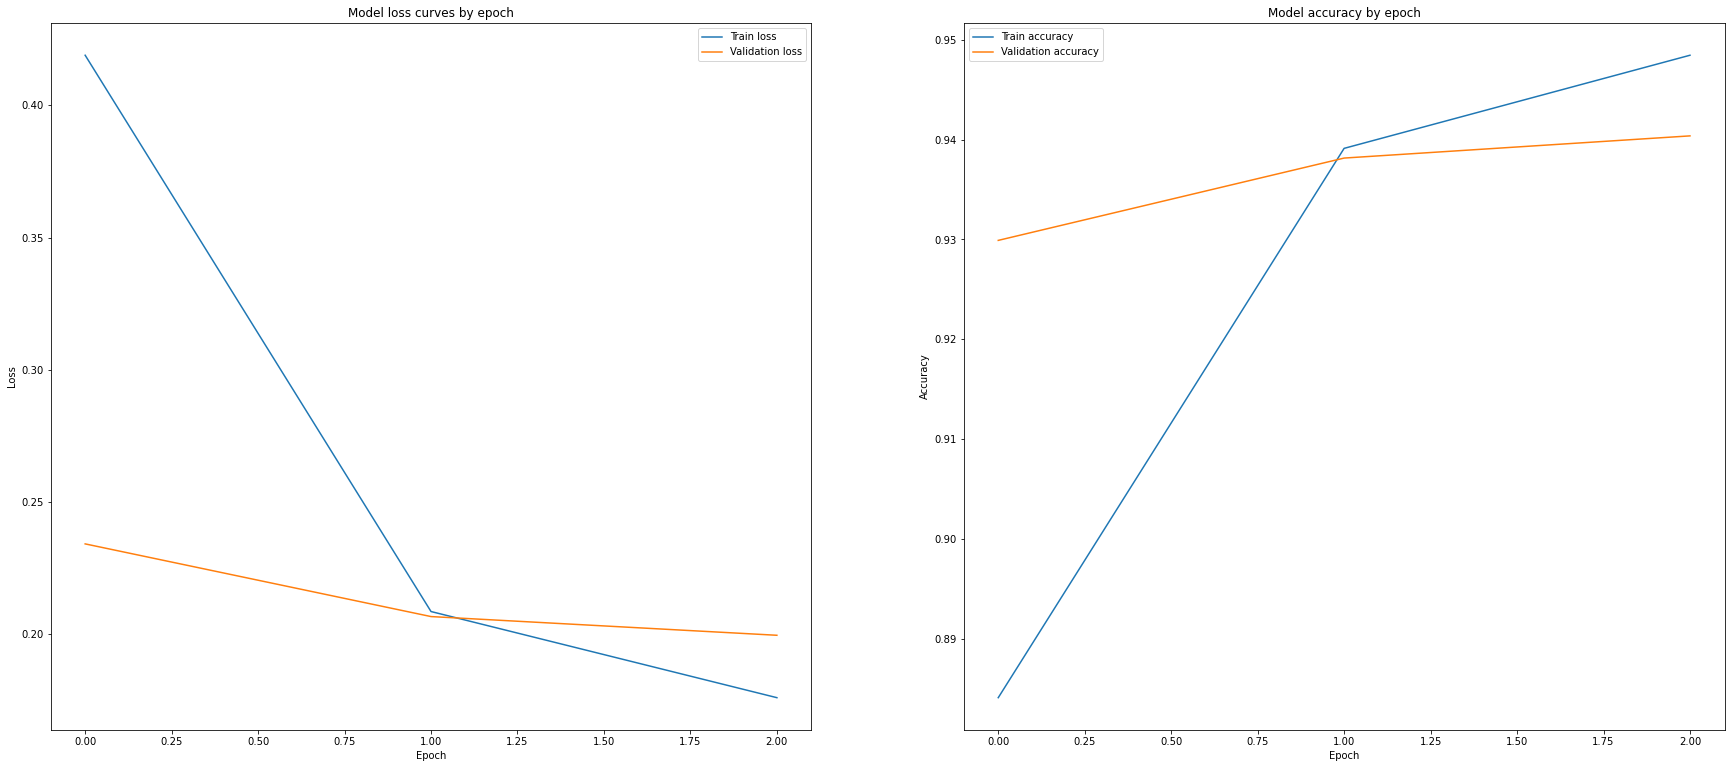

In [17]:
plot_loss(history=pos_history, title_loss="Model loss curves by epoch", title_accuracy="Model accuracy by epoch")

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Question:
    </font>
</h3>

- We decided to look at accuracy as a metric. Explain why this choice is questionable.
- We propose to test the performance on data that contain unseen words during the train in the cell below run the evaluation on X_test_oov and Y_test_oov.

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

**1. Critique of Accuracy as a Metric:**
<p style="text-align: justify">
    Accuracy is the measure used to determine which model best predicts our variable of interest. It is the overall rate of good predictions represented by the proportion of predictions correctly labeled by the model (true positives and negatives) relative to the total number of observations in the data set.
However, the main problem with this metric is that it takes into account all the correct predictions, whether the event variable is equal to 1 or 0. However, our objective is to determine if the event in question occurs and not if it does not occur. So the accuracy can be very high but for cases that we will not really take into account. Indeed, in cases of imbalance, a high accuracy means that the model predicts very well the non-occurrence of the event (because the algorithm has a lot of observations in this class), but does not predict well its occurrence (because the algorithm has very few observations to carry out its learning).
</p>

Here we can see imbalances in the training set for example: 
- there are 168,560 "NC" tags or 97,446 "P" tags versus only 3 "DETWH" tags or 4 "I" tags.

In [18]:
pos_tag_model.evaluate(X_test_oov, Y_test_oov)

1168/1168 [==============================] - 1s 914us/step - loss: 0.3135 - accuracy: 0.9086


[0.313527375459671, 0.9086310863494873]

**2. Comment on the model results:**

<p style="text-align: justify">
    First, thanks to our graph, we were able to look at the difference between the loss of the training game and validation as the epochs progressed. We can see that our model is not plagued by over-learning. Secondly, the method <span style="background:#ECF6CE">.evaluate()</span> returns the value of the loss on the game "out of vocabulary": it is 0.3135. Then second, the accuracy value on the same game: it is 0.9086.
</p>

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Instruction
        </font>
    </h2>
</div>

- Determine what is the best window size according to you (test several hypotheses among 3, 5 and 7)
- Rework the code for the following different hypotheses with the window size chosen above:
    1. embedding random not trainable
    2. embedding pre-trainer (wv) trainable
    3. embedding pre-trainer (wv) not trainable


<h3 style="font-family: Arial">
    <font color="#0E1117">
        Question:
    </font>
</h3>

- Conclude by testing on X_test_oov and Y_test_oov :
    - Which method would you choose and why? 
    - Can you intuitively explain the different results? 

In [19]:
def pos_embedding_classifier(embedding_input: int, embedding_trainable: bool, method: str, embedding_weight=None,
                             verbose: bool=False, plot: bool=False) -> pd.core.frame.DataFrame:
    """
    Function that allows to train a neural network with a fixed architecture:
    Embedding (input) > Flatten > Dense > Dropout > Dense > Dropout > Dense (output)
    
    Here, we train 3 neural networks with the same architecture but by modifying the parameters of the 
    embedding layer:
    - The size of the window defined during the split between the training and the test set (e.g. the length 
      of input sequences).
    - Add a pre-trained embedding layer (weights already calculated) in order not to start from a random 
      embeddings.
    - If the vector representation also benefits, or not, from backpropagation.
        
    Parameters
    ----------
    embedding_input : int
        The number of inputs that the network embedding layer must take. This is the size of the vocabulary, e.g. 
        maximum integer index + 1.
        
    embedding_weight : {None, list}, optional, default=None
        If we want a network with weights of words within the corpus already trained, it is possible to define 
        the weights already calculated and put them in input in the embedding layer. Default is None.
        
    embedding_trainable : bool
        If this is true, then the vector representation also benefits from backpropagation.
        
    method : str
        String indicating the method used to train the network.
        
    verbose : bool, optional, default=False
        If false, the logs will not be displayed when computing the neural network. Default is False.
        
    plot : bool, optional, default=False
        If false, We don't plot the loss and accuracy curves on the training and validation set by epoch. 
        Default is False.

    Returns
    -------
    pd.core.frame.DataFrame
        Dataframe containing the results (loss and accuracy) of the 3 networks trained on a test set (out of 
        vocabulary dataset).

    """
    # Rolling window
    wsize = [3, 5, 7]

    # Stock area
    evaluate_score = {}
    
    for window in wsize:
        # Train set
        docs_train = du.load_dataset(data+"train.txt")
        X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=window) 

        # Test set
        docs_test = du.load_dataset(data+"test.txt")
        X_test, y_test = du.docs_to_windows(docs_test, word_to_num, tag_to_num, wsize=window)

        # One Hot Encoding
        y_train = to_categorical(y_train, len(tagnames))
        y_test = to_categorical(y_test, len(tagnames))

        # Out of vocabulary set
        X_test_oov, Y_test_oov = du.get_oov(X_train, y_train, X_test, y_test)

        # Model
        model = pos_classifier(
            embedding_input=embedding_input, 
            embedding_output=50, 
            embedding_length=window,
            embedding_trainable=embedding_trainable, 
            output_dim=len(tagnames),
            embedding_weight=embedding_weight
        )

        # Compile the model
        model.compile(
            loss="categorical_crossentropy",
            optimizer="RMSprop",
            metrics=["accuracy"]
        )

        # Fit the model
        if verbose:
            print(f"Fitting model with {method} and window size fixed at {window}")
        else:
            pass
        
        history = model.fit(
            X_train, y_train, 
            epochs=3, 
            batch_size=300,
            validation_data=(X_test, y_test),
            verbose=verbose
        )

        print("-"*65)

        # Control loss and accuracy
        if plot:
            print(f"Loss and Accuracy curves for {method} model and window size fixed at {window}")
            plot_loss(
                history=history,
                title_loss=f"Model loss curves by epoch for wsize={window}",
                title_accuracy=f"Model accuracy by epoch for wsize={window}"
            )

            print("-"*65)
        else:
            pass

        # Evaluate the model
        if verbose:
            print(f"Evaluate model with {method} and window size fixed at {window}")
        else:
            pass
        
        evaluate_score["POS classifier wsize="+str(window)] = model.evaluate(
            X_test_oov, Y_test_oov,
            verbose=verbose
        )

        print("\n")

    print("Evaluation of the models with out of vocabulary dataset")
    dataframe = pd.DataFrame(evaluate_score, index=["Loss", "Accuracy"]).T
    dataframe = dataframe.round(decimals=4)
    
    return dataframe

<h3 style="font-family: Arial">
    <font color="#0E1117">
        1. embedding random non entrainable
    </font>
</h3>

Fitting model with random and non-trainable embedding and window size fixed at 3
Epoch 1/3
2268/2268 [==============================] - 7s 3ms/step - loss: 1.1316 - accuracy: 0.6683 - val_loss: 0.7662 - val_accuracy: 0.7634
Epoch 2/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.7446 - accuracy: 0.7731 - val_loss: 0.6149 - val_accuracy: 0.8105
Epoch 3/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.6500 - accuracy: 0.8018 - val_loss: 0.5535 - val_accuracy: 0.8313
-----------------------------------------------------------------
Loss and Accuracy curves for random and non-trainable embedding model and window size fixed at 3


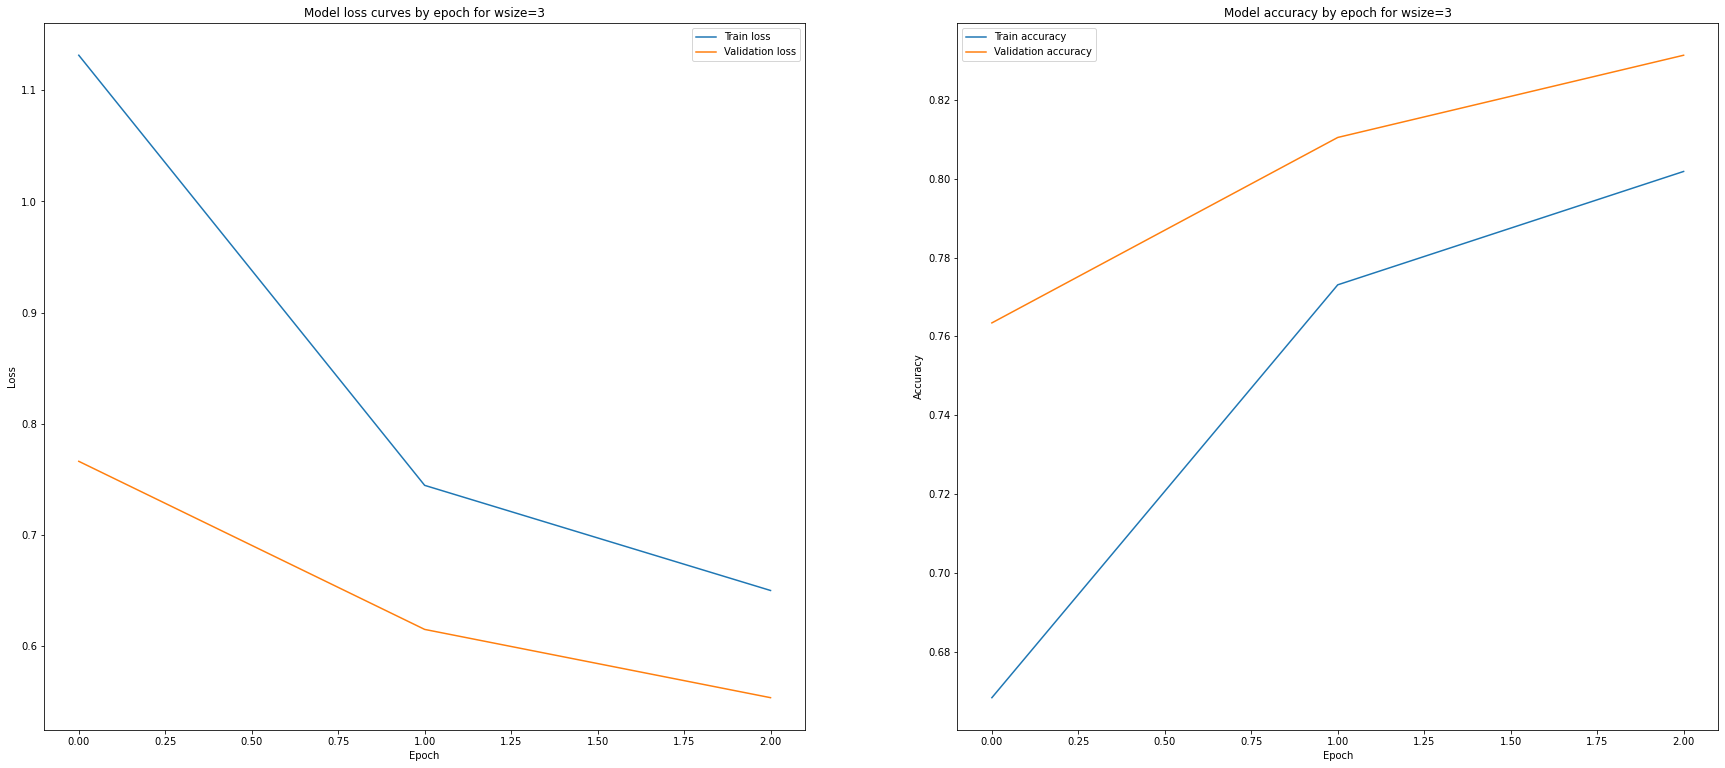

-----------------------------------------------------------------
Evaluate model with random and non-trainable embedding and window size fixed at 3
779/779 [==============================] - 1s 902us/step - loss: 0.7103 - accuracy: 0.7845


Fitting model with random and non-trainable embedding and window size fixed at 5
Epoch 1/3
2268/2268 [==============================] - 8s 3ms/step - loss: 1.1266 - accuracy: 0.6762 - val_loss: 0.7671 - val_accuracy: 0.7718
Epoch 2/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.7389 - accuracy: 0.7802 - val_loss: 0.6138 - val_accuracy: 0.8136
Epoch 3/3
2268/2268 [==============================] - 8s 3ms/step - loss: 0.6399 - accuracy: 0.8080 - val_loss: 0.5495 - val_accuracy: 0.8330
-----------------------------------------------------------------
Loss and Accuracy curves for random and non-trainable embedding model and window size fixed at 5


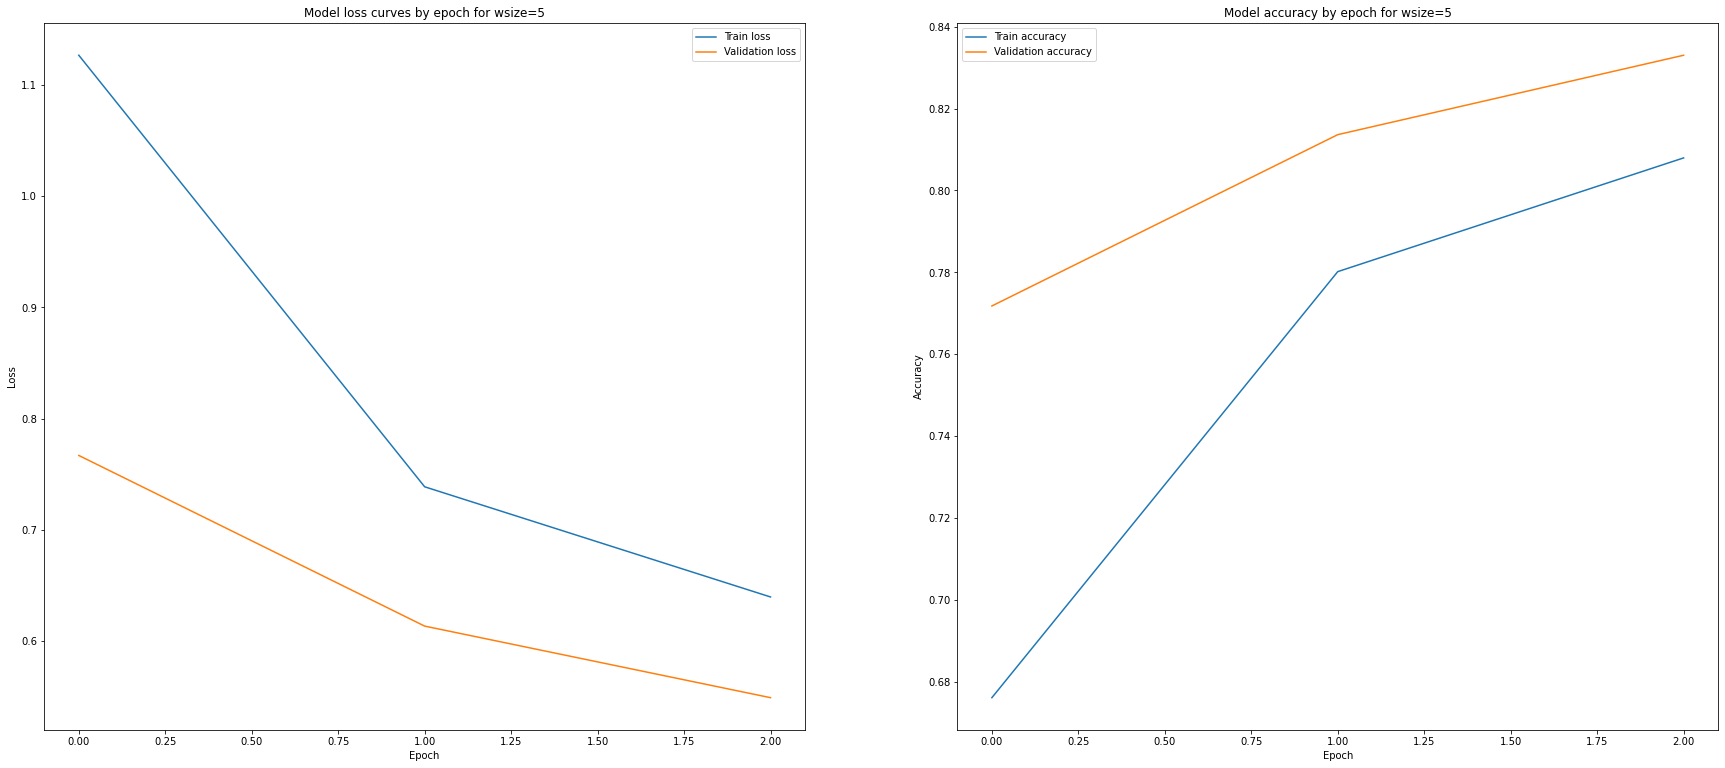

-----------------------------------------------------------------
Evaluate model with random and non-trainable embedding and window size fixed at 5
1168/1168 [==============================] - 1s 908us/step - loss: 0.6380 - accuracy: 0.8100


Fitting model with random and non-trainable embedding and window size fixed at 7
Epoch 1/3
2268/2268 [==============================] - 9s 4ms/step - loss: 1.1566 - accuracy: 0.6662 - val_loss: 0.7784 - val_accuracy: 0.7667
Epoch 2/3
2268/2268 [==============================] - 9s 4ms/step - loss: 0.7506 - accuracy: 0.7751 - val_loss: 0.6164 - val_accuracy: 0.8119
Epoch 3/3
2268/2268 [==============================] - 11s 5ms/step - loss: 0.6502 - accuracy: 0.8032 - val_loss: 0.5558 - val_accuracy: 0.8292
-----------------------------------------------------------------
Loss and Accuracy curves for random and non-trainable embedding model and window size fixed at 7


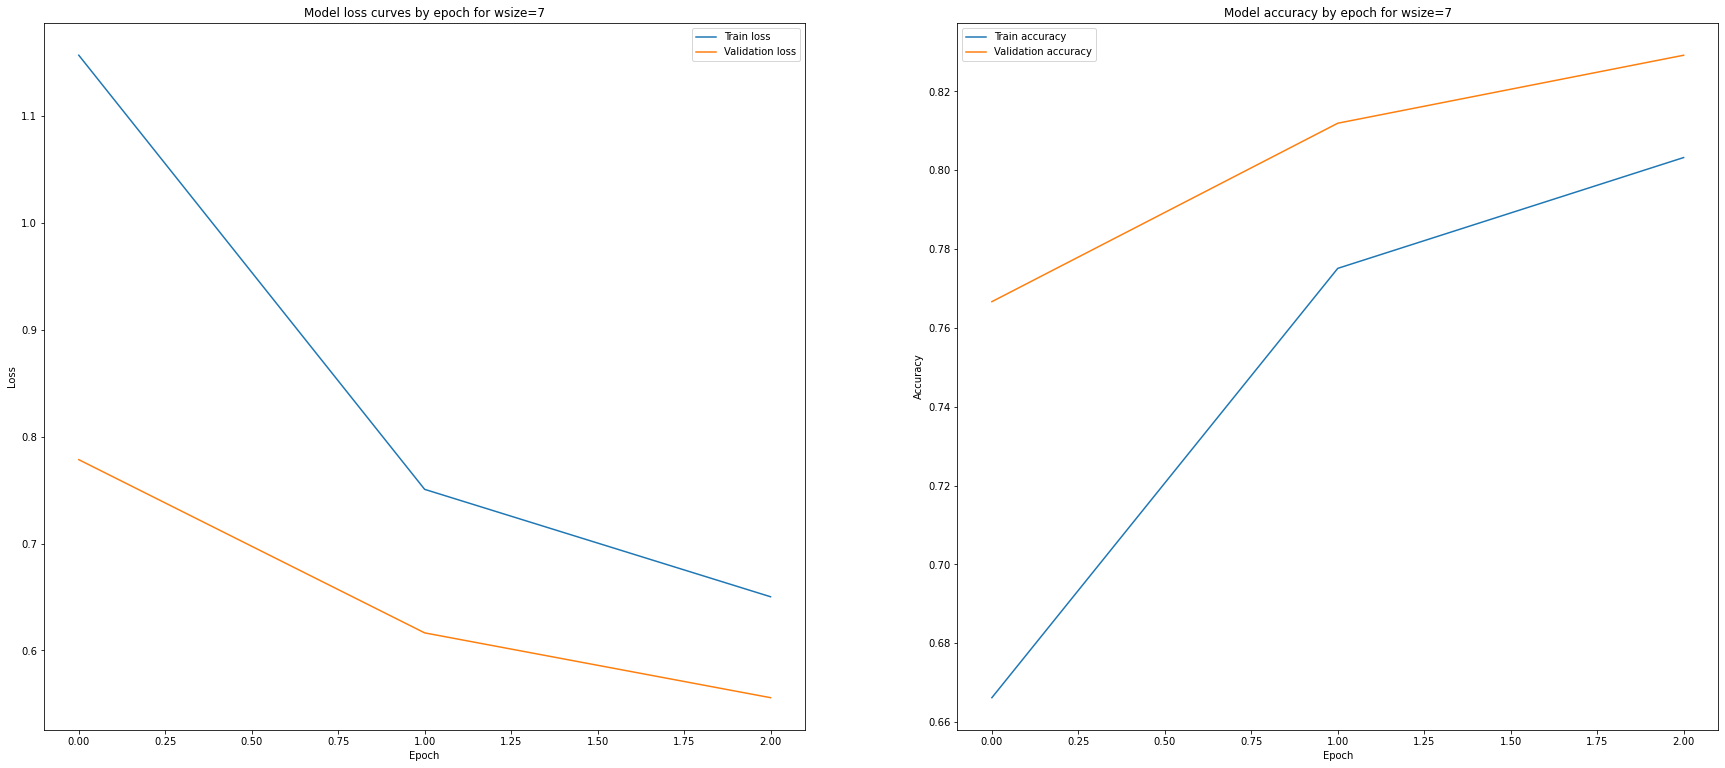

-----------------------------------------------------------------
Evaluate model with random and non-trainable embedding and window size fixed at 7
1485/1485 [==============================] - 2s 1ms/step - loss: 0.6105 - accuracy: 0.8159


Evaluation of the models with out of vocabulary dataset


,Loss,Accuracy
POS classifier wsize=3,0.7103,0.7845
POS classifier wsize=5,0.6380,0.8100
POS classifier wsize=7,0.6105,0.8159


In [20]:
pos_embedding_classifier(
    embedding_input=find_input_dim(X_train, X_test),
    embedding_weight=None,
    embedding_trainable=False,
    method="random and non-trainable embedding",
    verbose=True,
    plot=True
)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        2. embedding pre-trainer (wv) trainable
    </font>
</h3>

Fitting model with pre-trained and trainable embedding and window size fixed at 3
Epoch 1/3
2268/2268 [==============================] - 38s 17ms/step - loss: 0.3807 - accuracy: 0.8946 - val_loss: 0.2297 - val_accuracy: 0.9316
Epoch 2/3
2268/2268 [==============================] - 38s 17ms/step - loss: 0.2311 - accuracy: 0.9330 - val_loss: 0.2124 - val_accuracy: 0.9369
Epoch 3/3
2268/2268 [==============================] - 42s 19ms/step - loss: 0.2120 - accuracy: 0.9378 - val_loss: 0.2066 - val_accuracy: 0.9382
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and trainable embedding model and window size fixed at 3


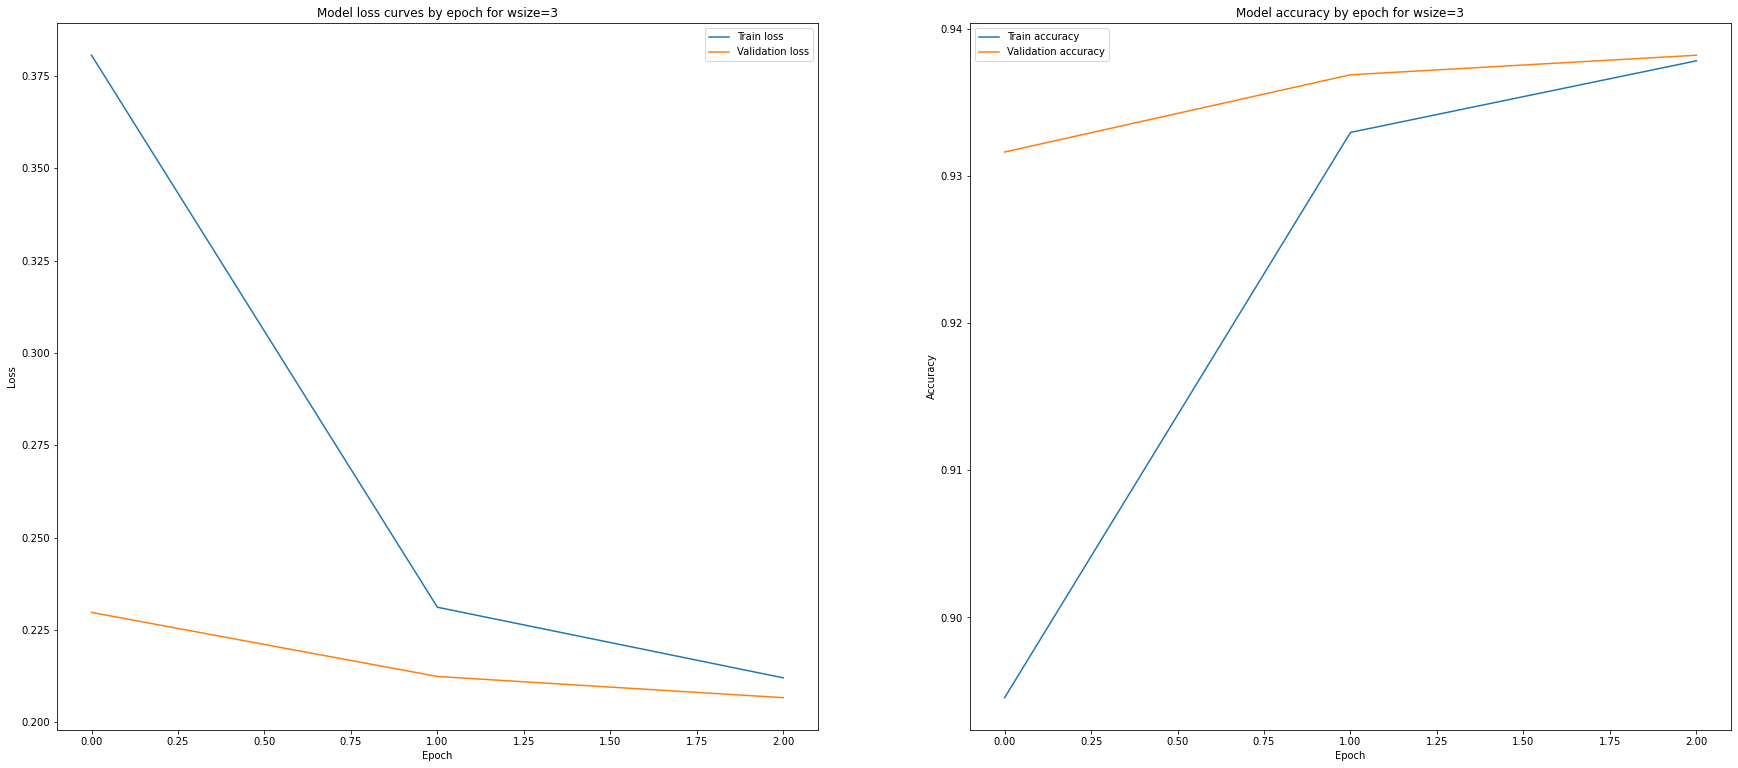

-----------------------------------------------------------------
Evaluate model with pre-trained and trainable embedding and window size fixed at 3
779/779 [==============================] - 1s 884us/step - loss: 0.3462 - accuracy: 0.8964


Fitting model with pre-trained and trainable embedding and window size fixed at 5
Epoch 1/3
2268/2268 [==============================] - 42s 18ms/step - loss: 0.3842 - accuracy: 0.8932 - val_loss: 0.2206 - val_accuracy: 0.9339
Epoch 2/3
2268/2268 [==============================] - 42s 19ms/step - loss: 0.2205 - accuracy: 0.9360 - val_loss: 0.2014 - val_accuracy: 0.9399
Epoch 3/3
2268/2268 [==============================] - 40s 18ms/step - loss: 0.1963 - accuracy: 0.9420 - val_loss: 0.1941 - val_accuracy: 0.9419
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and trainable embedding model and window size fixed at 5


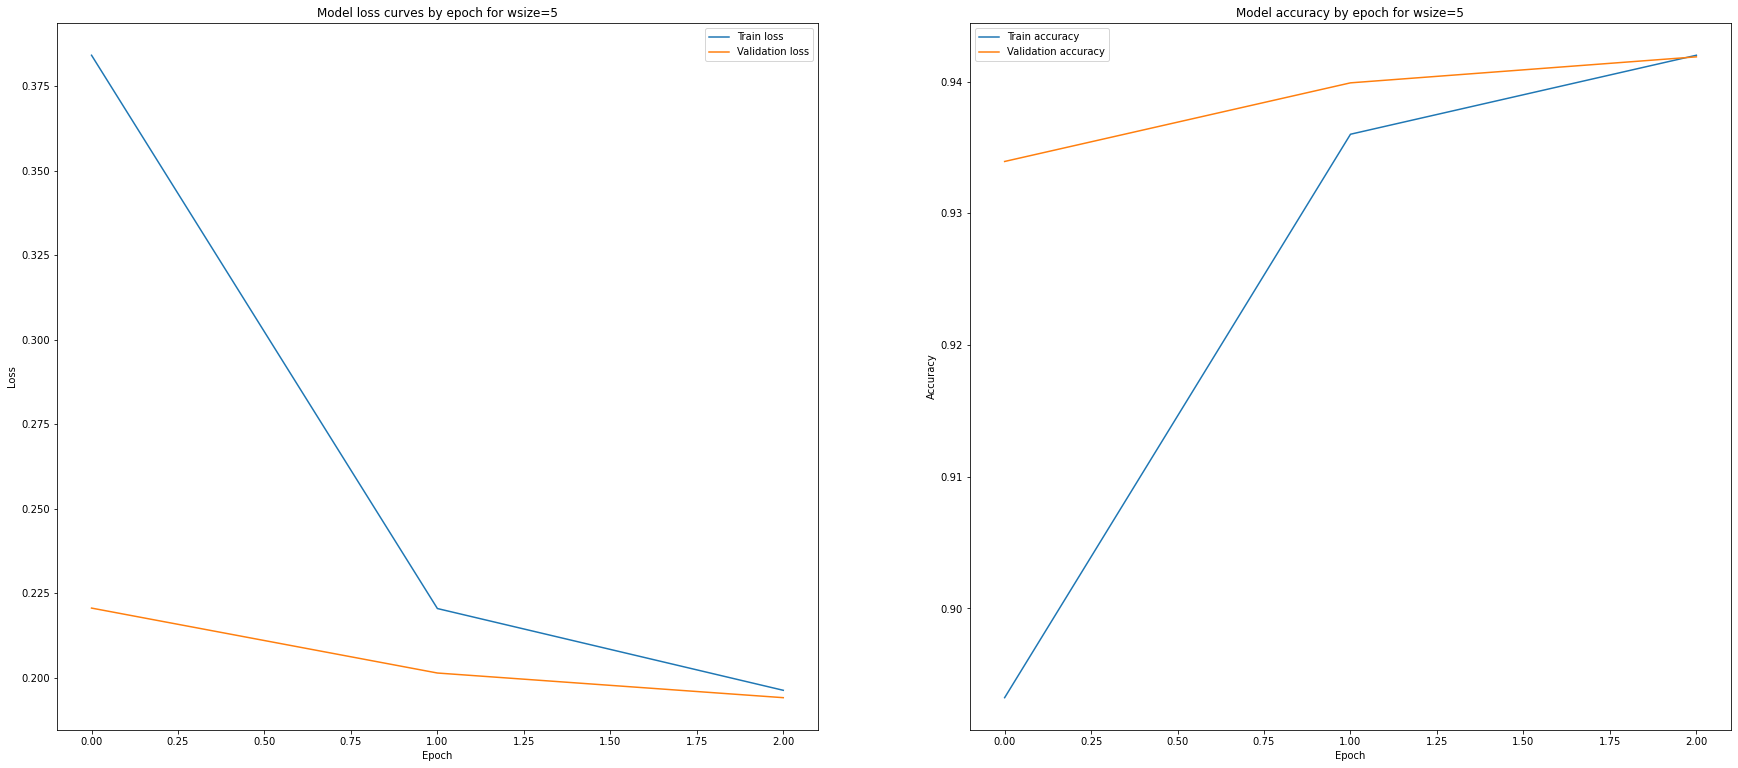

-----------------------------------------------------------------
Evaluate model with pre-trained and trainable embedding and window size fixed at 5
1168/1168 [==============================] - 1s 924us/step - loss: 0.2814 - accuracy: 0.9186


Fitting model with pre-trained and trainable embedding and window size fixed at 7
Epoch 1/3
2268/2268 [==============================] - 38s 16ms/step - loss: 0.3936 - accuracy: 0.8910 - val_loss: 0.2227 - val_accuracy: 0.9340
Epoch 2/3
2268/2268 [==============================] - 42s 19ms/step - loss: 0.2213 - accuracy: 0.9353 - val_loss: 0.2044 - val_accuracy: 0.9393
Epoch 3/3
2268/2268 [==============================] - 39s 17ms/step - loss: 0.1953 - accuracy: 0.9422 - val_loss: 0.2007 - val_accuracy: 0.9407
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and trainable embedding model and window size fixed at 7


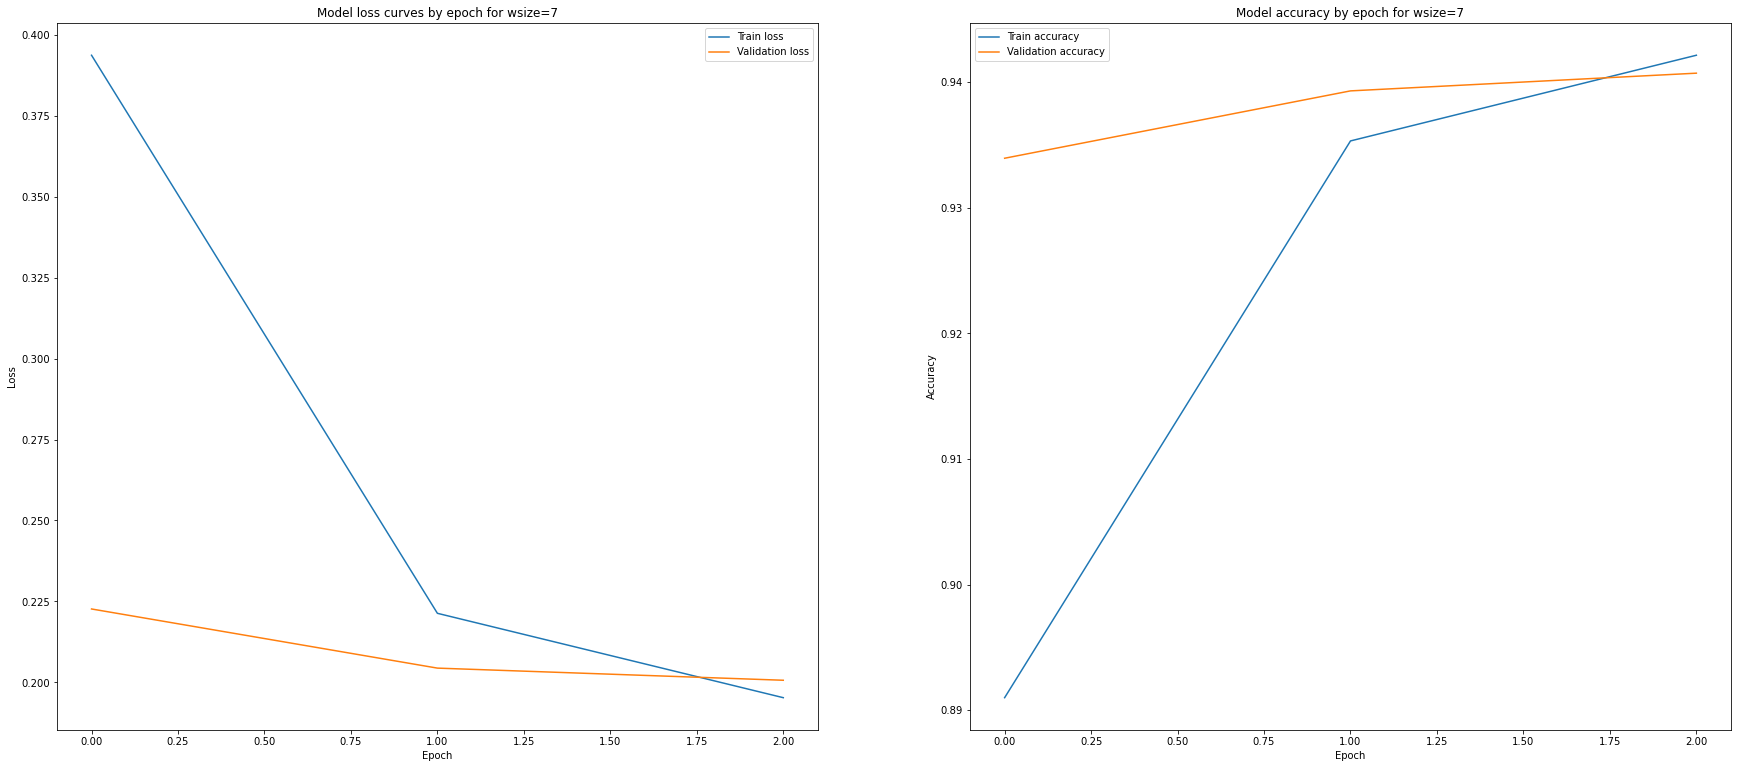

-----------------------------------------------------------------
Evaluate model with pre-trained and trainable embedding and window size fixed at 7
1485/1485 [==============================] - 1s 910us/step - loss: 0.2585 - accuracy: 0.9247


Evaluation of the models with out of vocabulary dataset


,Loss,Accuracy
POS classifier wsize=3,0.3462,0.8964
POS classifier wsize=5,0.2814,0.9186
POS classifier wsize=7,0.2585,0.9247


In [21]:
pos_embedding_classifier(
    embedding_input=len(wv),
    embedding_weight=[wv],
    embedding_trainable=True,
    method="pre-trained and trainable embedding",
    verbose=True,
    plot=True
)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        3 embedding pre-trainer (wv) non trainable
    </font>
</h3>

Fitting model with pre-trained and non-trainable embedding and window size fixed at 3
Epoch 1/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.4975 - accuracy: 0.8634 - val_loss: 0.2998 - val_accuracy: 0.9141
Epoch 2/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.3243 - accuracy: 0.9082 - val_loss: 0.2685 - val_accuracy: 0.9216
Epoch 3/3
2268/2268 [==============================] - 6s 3ms/step - loss: 0.2988 - accuracy: 0.9143 - val_loss: 0.2576 - val_accuracy: 0.9249
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and non-trainable embedding model and window size fixed at 3


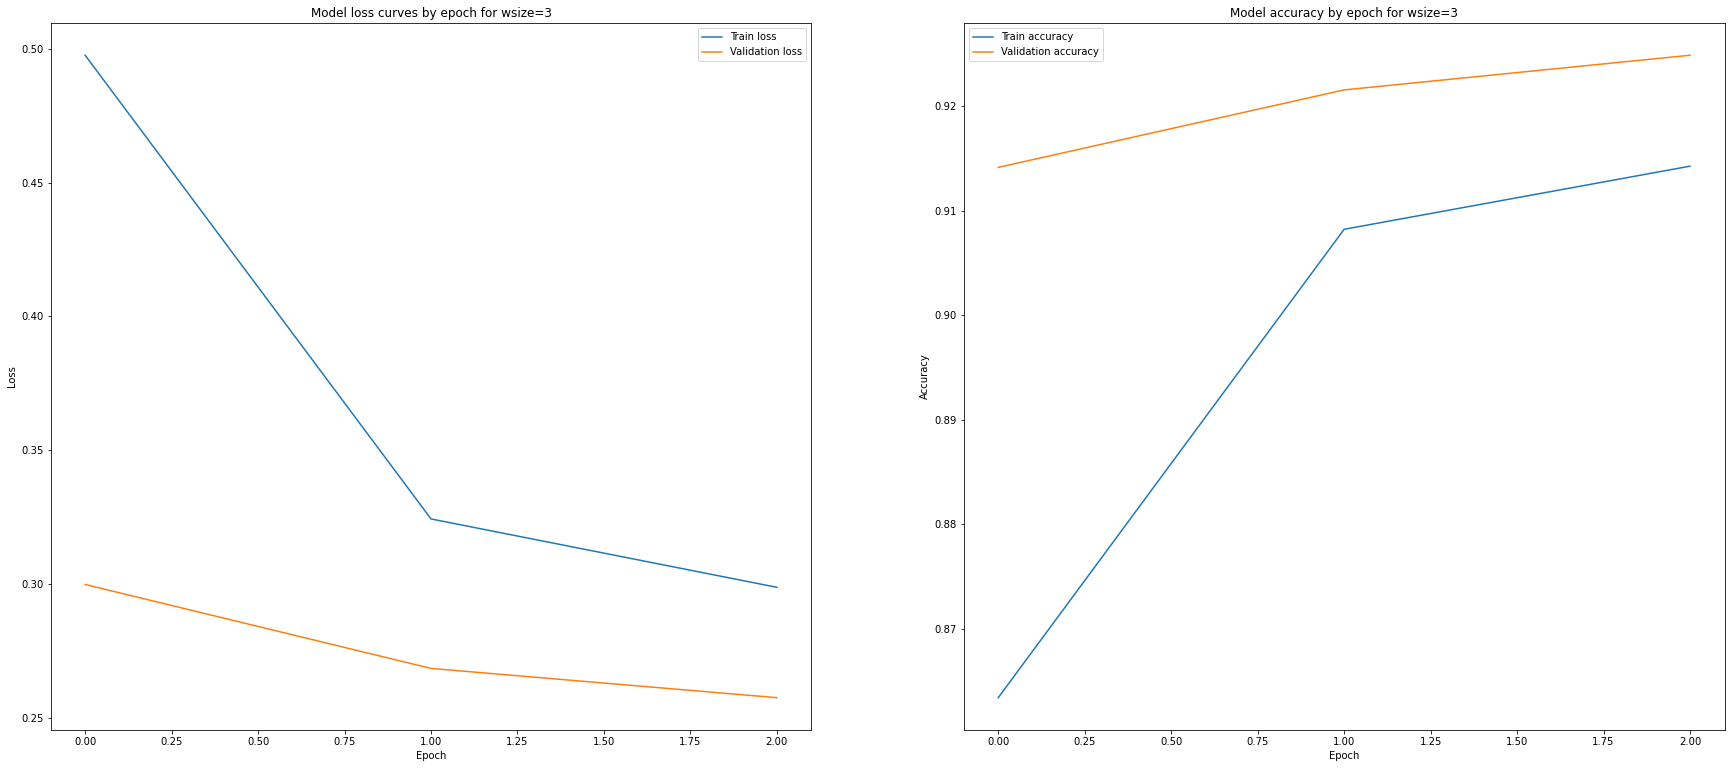

-----------------------------------------------------------------
Evaluate model with pre-trained and non-trainable embedding and window size fixed at 3
779/779 [==============================] - 1s 871us/step - loss: 0.3892 - accuracy: 0.8872


Fitting model with pre-trained and non-trainable embedding and window size fixed at 5
Epoch 1/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.5037 - accuracy: 0.8595 - val_loss: 0.2990 - val_accuracy: 0.9138
Epoch 2/3
2268/2268 [==============================] - 8s 3ms/step - loss: 0.3188 - accuracy: 0.9092 - val_loss: 0.2640 - val_accuracy: 0.9222
Epoch 3/3
2268/2268 [==============================] - 7s 3ms/step - loss: 0.2932 - accuracy: 0.9156 - val_loss: 0.2520 - val_accuracy: 0.9261
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and non-trainable embedding model and window size fixed at 5


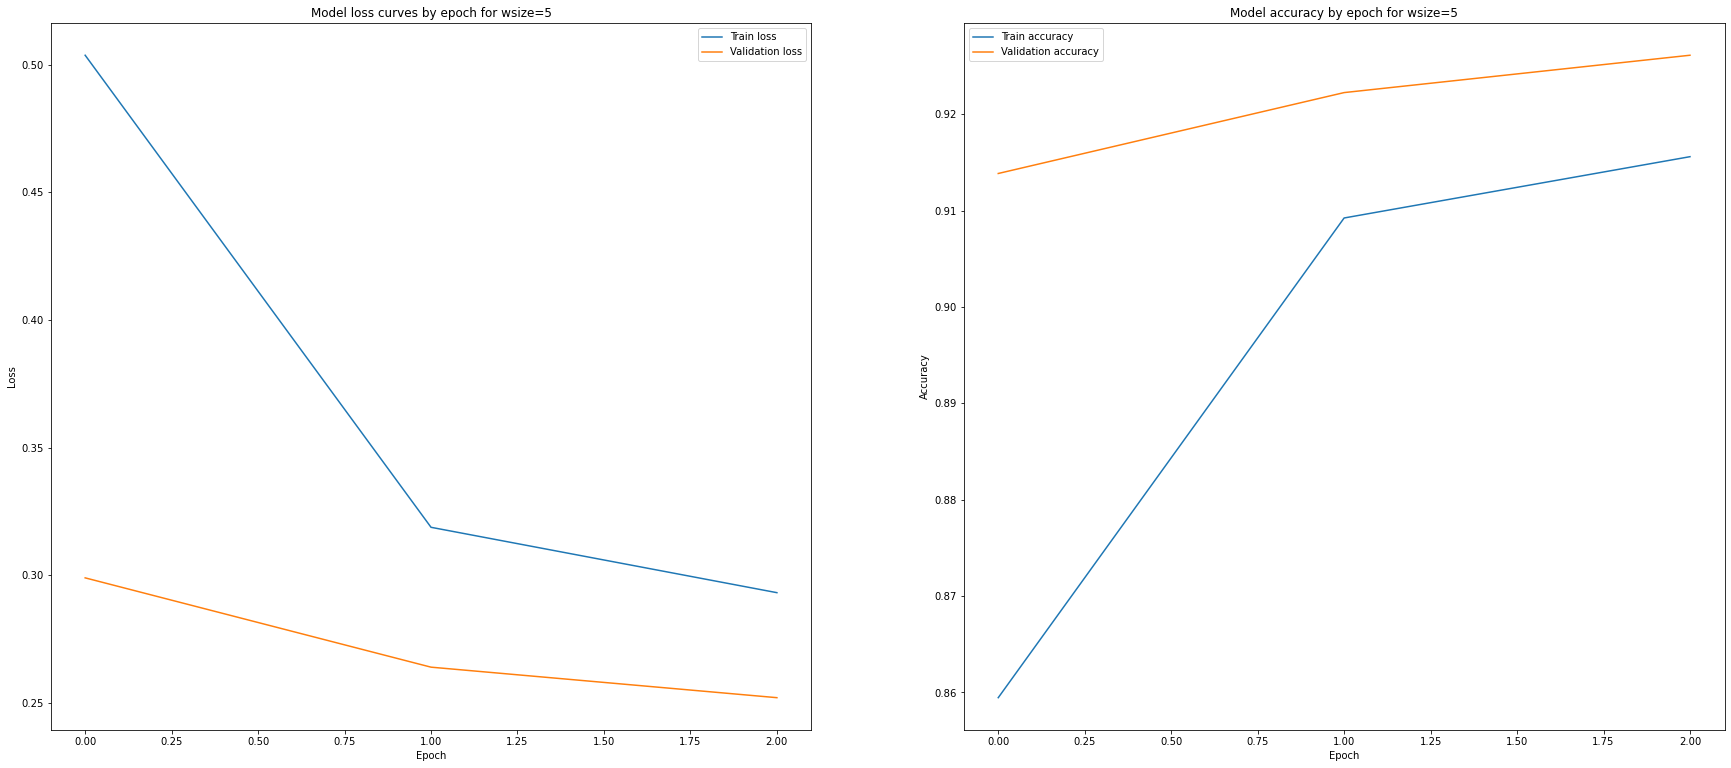

-----------------------------------------------------------------
Evaluate model with pre-trained and non-trainable embedding and window size fixed at 5
1168/1168 [==============================] - 1s 898us/step - loss: 0.3297 - accuracy: 0.9057


Fitting model with pre-trained and non-trainable embedding and window size fixed at 7
Epoch 1/3
2268/2268 [==============================] - 10s 4ms/step - loss: 0.5225 - accuracy: 0.8537 - val_loss: 0.3049 - val_accuracy: 0.9121
Epoch 2/3
2268/2268 [==============================] - 9s 4ms/step - loss: 0.3278 - accuracy: 0.9066 - val_loss: 0.2719 - val_accuracy: 0.9205
Epoch 3/3
2268/2268 [==============================] - 8s 4ms/step - loss: 0.2994 - accuracy: 0.9138 - val_loss: 0.2606 - val_accuracy: 0.9237
-----------------------------------------------------------------
Loss and Accuracy curves for pre-trained and non-trainable embedding model and window size fixed at 7


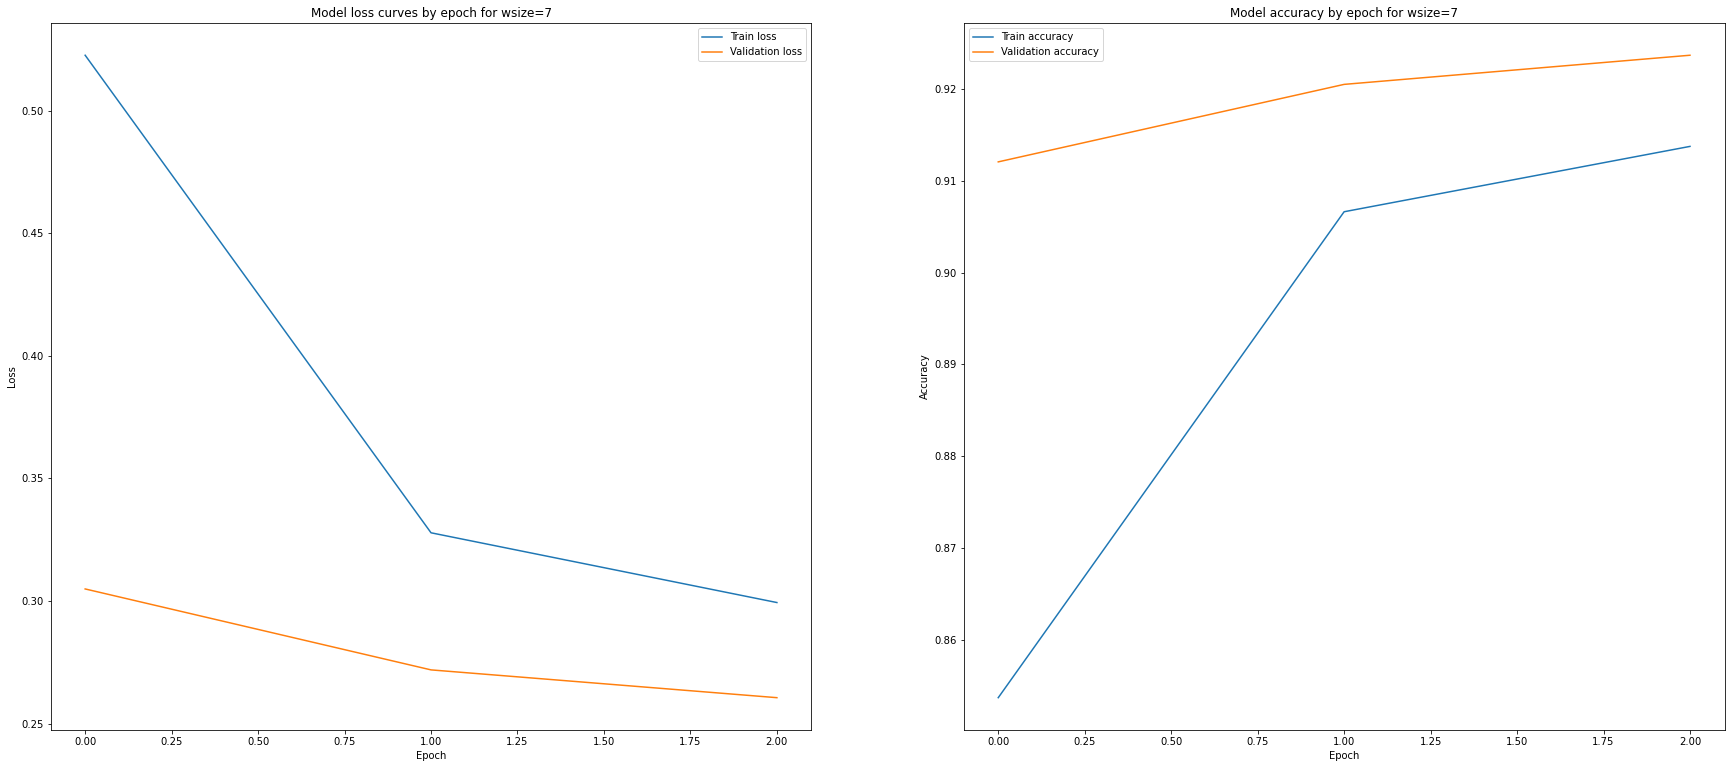

-----------------------------------------------------------------
Evaluate model with pre-trained and non-trainable embedding and window size fixed at 7
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3142 - accuracy: 0.9096


Evaluation of the models with out of vocabulary dataset


,Loss,Accuracy
POS classifier wsize=3,0.3892,0.8872
POS classifier wsize=5,0.3297,0.9057
POS classifier wsize=7,0.3142,0.9096


In [22]:
pos_embedding_classifier(
    embedding_input=len(wv),
    embedding_weight=[wv],
    embedding_trainable=False,
    method="pre-trained and non-trainable embedding",
    verbose=True,
    plot=True
)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

- **Can you explain the different results intuitively?**
- **Which method would you choose and why?**

<u><strong>Observations :</strong></u>

<ol>
    <li style="text-align: justify">Regardless of the method chosen (with pre-trained weights or by applying, or not, backpropagation to the vector representation of the embedding layer), the loss and accuracy of the neural network, on the "out of vocabulary" test set, are better for a window size fixed at 7. Thus we could say that no matter the method, the larger the window size the better the performance of the network. <span style="background:#ECF6CE">It makes sense, taking into account more words, before and after the word under consideration, allows us to better place the context of the word and thus better predict its grammatical position.</span></li>
    <li style="text-align: justify">Depending on the method tested, we notice differences in terms of execution time. First, it seems that the larger the window size, the longer the training time of the model. Secondly, the execution time will considerably depend on the chosen method:</li>
        <ul>
        <li style="text-align: justify">1) embedding random non-trainable (False) : average execution time of 7.7 seconds per epoch.</li>
        <li style="text-align: justify">2) pre-trained embedding (wv) trainable (True): average execution time of 39.9 seconds per epoch.</li>
        <li style="text-align: justify">3) pre-trained embedding (wv) non-trainable (False): average execution time of 8.6 seconds per epoch.</li>
        </ul>
    <li style="text-align: justify">Implementing a pre-trained embedding layer increases the training time very slightly, but allows to increase very largely (+10 points) the accuracy of the network and decrease considerably the loss on the "out of vocabulary" test set. <span style="background:#ECF6CE">(difference between method 1 vs method 3)</span></li>
    <li style="text-align: justify">Implementing a pre-trained embedding layer + applying backpropagation to the vector representation of the embedding greatly increases the computation time. On the other hand, this is the method providing the best performance, in terms of loss value and accuracy (+ 1/2 points of accuracy), on the "out of vocabulary" test set. <span style="background:#ECF6CE">(method 2)</span></li>
</ol>


<u><strong>Conclusion :</strong></u>
<ul>
    <li style="text-align: justify"><strong>Method 1</strong>: Requires the least learning time but provides the least performance. If we look at the loss graphs, we see that this is the method involving the most overlearning among the 3 methods (difference between the training loss and the validation loss).</li>
    <li style="text-align: justify"><strong>Method 2</strong>: Requires the most learning time but provides the best performance. Moreover, it is the method that involves the least gap between training and validation loss (i.e. overlearning).</li>
    <li style="text-align: justify"><strong>Method 3</strong>: Requires a low execution time compared to method 2 but slightly more than method 1. On the other hand, it brings much better performances on the "out of vocabulary" test set than method 1 but slightly less good than method 2.</li>
</ul>


<u><strong>Note :</strong></u>
<p style="text-align: justify">
    Basically, we can ask ourselves a question: is it really useful to implement a method whose execution time is much greater, by epoch, for a gain of 1 or 2 points of accuracy? In other words, are these additional 30 seconds of training, per epoch, really worth for the gain of 1 or 2 points of accuracy?The execution time can be expensive in some use case in business for example. In our case, here, if we had to choose one of these 3 methods, I would choose the one providing the best results and the least over-learning: the <span style="background:#ECF6CE">method 2</span> (pre-trained embedding layer + apply backpropagation to the vector representation of the embedding) associated with a sequence size set at 7.
</p>

<h1 style="font-family: Arial">
    <font color="#0E1117">
        Shallow Parsing
    </font>
</h1>

<br/>

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Instruction
        </font>
    </h2>
</div>

<br/>

- Resume the above methodology and train a shallow parsing model
- Tags are **['O','B-NP','I-NP','B-AP','I-AP','B-CONJ','I-CONJ','B-AdP','I-AdP','B-VN','I-VN','B-PP','I-PP','B-UNKNOWN','I-UNKNOWN']**
- The files are train_chunk.txt and test_chunk.txt
- Don't forget to recreate the out-of-vocabulary tests (X_test_oov and Y_test_oov)
- Conclude on your choice of the best model

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Word Embedding
    </font>
</h4>

In [23]:
wv_shallow, word_to_num_shallow, num_to_word_shallow = pos.load_wv(data+"vocab.txt", data+"wordVectors.txt")
print("wordvector shape is", wv_shallow.shape)

wordvector shape is (100003, 50)


<h4 style="font-family: Arial">
    <font color="#0E1117">
        Création des tags
    </font>
</h4>

In [24]:
tagnames_shallow = ["O","B-NP","I-NP","B-AP","I-AP","B-CONJ","I-CONJ","B-AdP",
                    "I-AdP","B-VN","I-VN","B-PP","I-PP","B-UNKNOWN","I-UNKNOWN"]

num_to_tag_shallow = dict(enumerate(tagnames_shallow))
tag_to_num_shallow = {v:k for k, v in num_to_tag_shallow.items()}

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Data loading
    </font>
</h4>

In [25]:
docs_train_shallow = du.load_dataset(data+"train_chunk.txt")
X_train_shallow, y_train_shallow = du.docs_to_windows(
    docs_train_shallow,
    word_to_num_shallow,
    tag_to_num_shallow,
    wsize=5
)

In [26]:
docs_train_shallow[0]

[['paul', 'B-NP'],
 ['jules', 'I-NP'],
 ['antoine', 'B-NP'],
 ['meillet', 'I-PP'],
 [',', 'O'],
 ['né', 'B-NP'],
 ['le', 'B-NP'],
 ['à', 'I-NP'],
 ['moulins', 'I-PP'],
 ['(', 'O'],
 ['allier', 'B-NP'],
 [')', 'O'],
 ['et', 'B-CONJ'],
 ['mort', 'B-VN'],
 ['le', 'B-NP'],
 ['à', 'I-PP'],
 ['châteaumeillant', 'I-PP'],
 ['(', 'O'],
 ['cher', 'B-NP'],
 [')', 'O'],
 [',', 'O'],
 ['est', 'B-VN'],
 ['le', 'B-NP'],
 ['principal', 'I-NP'],
 ['linguiste', 'I-NP'],
 ['français', 'I-PP'],
 ['des', 'B-PP'],
 ['premières', 'I-PP'],
 ['décennies', 'I-PP'],
 ['du', 'I-PP'],
 ['.', 'O']]

In [27]:
docs_test_shallow = du.load_dataset(data+"test_chunk.txt")
X_test_shallow, y_test_shallow = du.docs_to_windows(
    docs_test_shallow,
    word_to_num_shallow,
    tag_to_num_shallow,
    wsize=5
)

In [28]:
y_train_shallow = to_categorical(y_train_shallow, len(tagnames_shallow))
y_test_shallow = to_categorical(y_test_shallow, len(tagnames_shallow))

In [29]:
X_test_oov_shallow, Y_test_oov_shallow = du.get_oov(
    X_train_shallow,
    y_train_shallow,
    X_test_shallow,
    y_test_shallow
)

In [30]:
print("X_train shape is", X_train_shallow.shape)
print("X_test shape is", X_test_shallow.shape)
print("y_train shape is", y_train_shallow.shape)
print("y_test shape is", y_test_shallow.shape)

X_train shape is (680238, 5)
X_test shape is (267334, 5)
y_train shape is (680238, 15)
y_test shape is (267334, 15)


<h4 style="font-family: Arial">
    <font color="#0E1117">
        Neural network creation
    </font>
</h4>

In [31]:
chunk_model = pos_classifier(
    embedding_input=find_input_dim(X_train_shallow, X_test_shallow),
    embedding_output=50,
    embedding_length=5,
    embedding_trainable=True,
    output_dim=len(tagnames_shallow),
    embedding_weight=None
)

In [32]:
chunk_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 5, 50)             1915400   
                                                                 
 flatten_10 (Flatten)        (None, 250)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               32128     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 DenseLayer2 (Dense)         (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 DenseLayer3 (Dense)         (None, 15)              

In [33]:
chunk_model.compile(
    loss="categorical_crossentropy",
    optimizer="RMSprop",
    metrics=["accuracy"]
)

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Training
    </font>
</h4>

In [34]:
chunk_history = chunk_model.fit(
    X_train_shallow, y_train_shallow, 
    epochs=3, 
    batch_size=300,
    validation_data=(X_test_shallow, y_test_shallow)
)

Epoch 1/3
2268/2268 [==============================] - 16s 7ms/step - loss: 0.4566 - accuracy: 0.8549 - val_loss: 0.2809 - val_accuracy: 0.9058
Epoch 2/3
2268/2268 [==============================] - 18s 8ms/step - loss: 0.2460 - accuracy: 0.9191 - val_loss: 0.2440 - val_accuracy: 0.9167
Epoch 3/3
2268/2268 [==============================] - 16s 7ms/step - loss: 0.1970 - accuracy: 0.9347 - val_loss: 0.2401 - val_accuracy: 0.9178


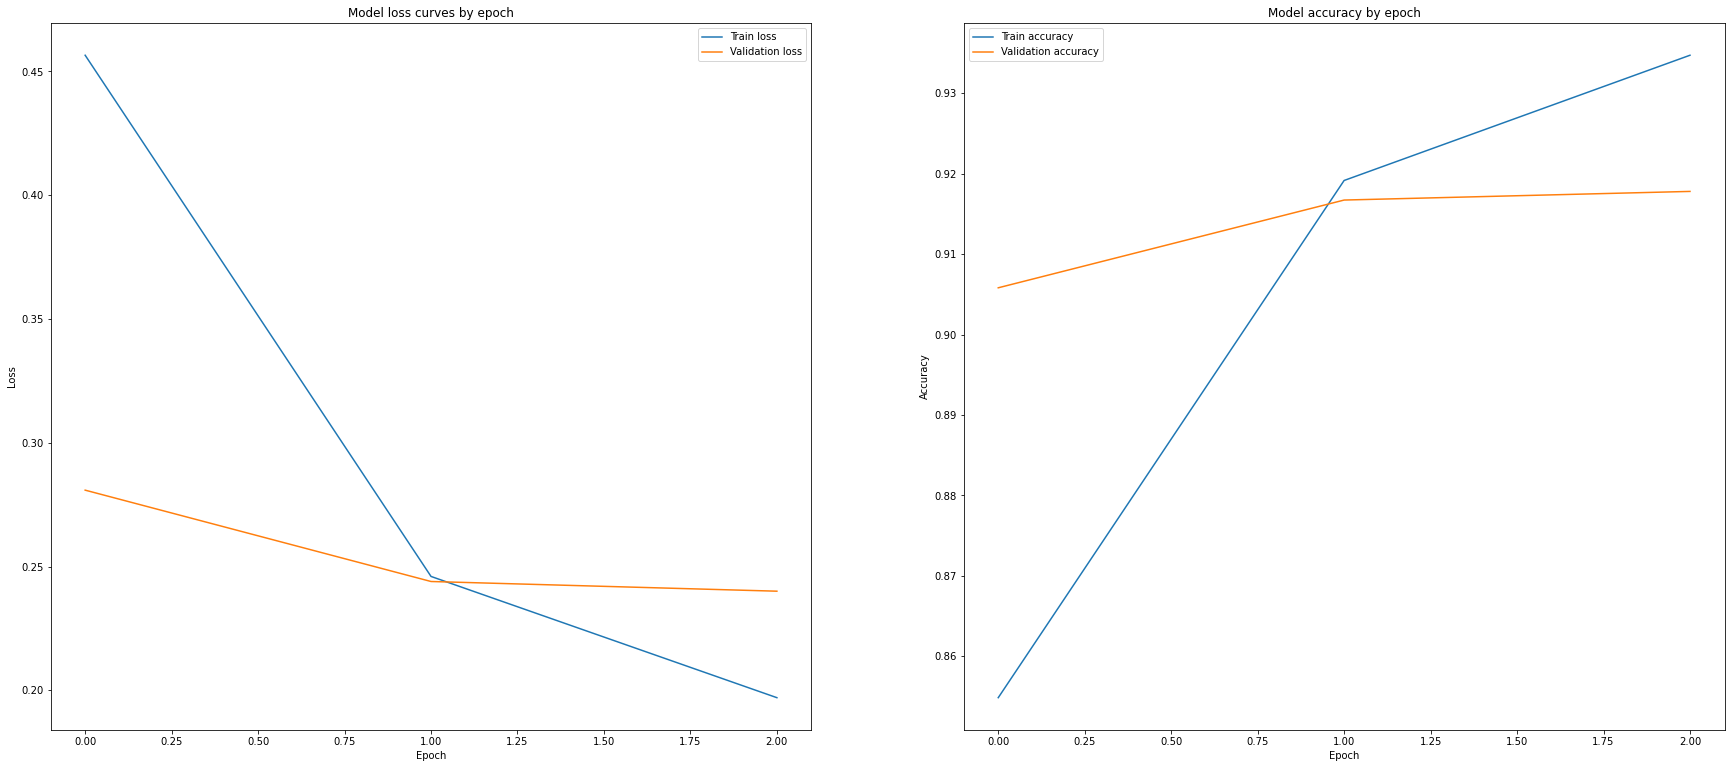

In [35]:
plot_loss(history=chunk_history, title_loss="Model loss curves by epoch", title_accuracy="Model accuracy by epoch")

In [36]:
chunk_model.evaluate(X_test_oov_shallow, Y_test_oov_shallow)

1168/1168 [==============================] - 2s 1ms/step - loss: 0.2448 - accuracy: 0.9197


[0.24480287730693817, 0.9197109341621399]

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

<p style='text-align: justify'>
    Overall, the performance of the two models is relatively close, in terms of accuracy, when evaluated with the method <span style="background:#ECF6CE">.evaluate()</span>. On the other hand, the <span style="background:#ECF6CE">Shallow-parsing model</span> is still better: a much lower loss and higher accuracy.
</p>

<h1 style="font-family: Arial">
    <font color="#0E1117">
        Multi-task learning
    </font>
</h1>

<br/>

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#0E1117">
            Full multi tagged (POS tagging + Shallow parsing)
        </font>
    </h2>
</div>

<br/>

<p style='text-align: justify'>In deep learning, it is possible and sometimes even recommended to train a neural network on several tasks at the same time. Intuitively, we think that learning a representation on a task should help on another task. This also allows us to have more data for example and/or to have a more robust, more precise model.</p>

<p style='text-align: justify'>In this part, we're going to rely on the <span style="background:#ECF6CE">.Model()</span> class from Keras (<a href="https://keras.io/getting-started/functional-api-guide/">functional-api-guide</a>). Rather than adding the layers, it's more about seeing each layer as a function. It's then a matter of chaining the functions together.</p>

<img src="image/mtl_images.png" style="width:300px;height:450px;">
<caption><center> <u>Figure 1</u>: Un exemple d'architecture pour apprendre 3 tâches</center></caption>

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Embedding
    </font>
</h4>

In [37]:
wv, word_to_num, num_to_word = pos.load_wv(data+"vocab.txt", data+"wordVectors.txt")
print("wordvector shape is", wv.shape)

wordvector shape is (100003, 50)


<h4 style="font-family: Arial">
    <font color="#0E1117">
        Tag creation
    </font>
</h4>

In [38]:
postagnames = ["ADJ","ADJWH","ADV","ADVWH","CC","CLO","CLR","CLS","CS","DET",
               "DETWH","ET","I","NC","NPP","P","P+D","P+PRO","PONCT","PREF",
               "PRO","PROREL","PROWH","VINF","VPR","VPP","V","VS","VIMP"]

num_to_postag = dict(enumerate(postagnames))
postag_to_num = {v:k for k, v in num_to_postag.items()}

In [39]:
chunktagnames = ["O","B-NP","I-NP","B-AP","I-AP","B-CONJ","I-CONJ","B-AdP",
                 "I-AdP","B-VN","I-VN","B-PP","I-PP","B-UNKNOWN","I-UNKNOWN"]

num_to_chunktag = dict(enumerate(chunktagnames))
chunktag_to_num = {v:k for k, v in num_to_chunktag.items()}

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Loading text data
    </font>
</h4>

In [40]:
# Load the training set
docs = du.load_dataset(data+"train.txt")
X_train, pos_train = du.docs_to_windows(docs, word_to_num, postag_to_num, wsize=5)

docs = du.load_dataset(data+"train_chunk.txt")
X_train, chunk_train = du.docs_to_windows(docs, word_to_num, chunktag_to_num, wsize=5)

In [41]:
docs = du.load_dataset(data+"test.txt")
X_test, pos_test = du.docs_to_windows(docs, word_to_num, postag_to_num, wsize=5)

docs = du.load_dataset(data+"test_chunk.txt")
X_test, chunk_test = du.docs_to_windows(docs, word_to_num, chunktag_to_num, wsize=5)

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Reshaping for learning
    </font>
</h4>

In [42]:
X_pos_train = X_train[:400000,:]

X_chunk_train = X_train[-400000:,]

In [43]:
Y_pos_train = to_categorical(pos_train[0:400000,], 29)
Y_pos_test = to_categorical(pos_test, 29)

Y_chunk_train = to_categorical(chunk_train[-400000:,], 15)
Y_chunk_test = to_categorical(chunk_test, 15)

In [44]:
print("X_pos_train shape is", X_pos_train.shape)
print("X_chunk_train shape is", X_chunk_train.shape)
print("X_test shape is", X_test.shape)
print("y_pos_train shape is", Y_pos_train.shape)
print("y_chunk_train shape is", Y_chunk_train.shape)
print("y_pos_test shape is", Y_pos_test.shape)
print("y_chunk_test shape is", Y_chunk_test.shape)

X_pos_train shape is (400000, 5)
X_chunk_train shape is (400000, 5)
X_test shape is (267334, 5)
y_pos_train shape is (400000, 29)
y_chunk_train shape is (400000, 15)
y_pos_test shape is (267334, 29)
y_chunk_test shape is (267334, 15)


<h4 style="font-family: Arial">
    <font color="#0E1117">
        Summary
    </font>
</h4>

So far we have :
- **wv** which contains an embedding.
- **X_pos_** and **Y_pos_** which contain respectively the words and the tag on train and test for pos-tagging.
- **X_chunk_** and **Y_chunk_** which contain respectively the words and the tag on train and test for shallow-parsing.
- **X_pos** and **X_chunk** have no windows in common.

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Creation of the neural network common to both tasks
    </font>
</h3>

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Instruction
    </font>
</h4>

Use the same architecture as above to build the shared neural network : shared_nn

In [45]:
# Keras sequential model
shared_nn = Sequential(
    [
        # Embedding layer
        Embedding(
            input_dim=np.max(X_test)+1, 
            output_dim=50, 
            input_length=5,
            trainable=True
        ),
        # Flatten layer
        Flatten(),
        # Dense layer
        Dense(
            128, 
            activation="relu",
            name="DenseLayer1"
        ),
        # Dropout layer
        Dropout(0.2),
        ## Dense layer
        Dense(
            64, 
            activation="relu",
            name="DenseLayer2"
        ),
        # Dropout layer
        Dropout(0.2)
    ], 
    name="MultitaskModel"
)

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Instruction
    </font>
</h4>

Define common neural network inputs using the class <span style="background:#ECF6CE">. Input()</span>. These are the input layers of our architecture, each corresponding to a task.

In [46]:
# We define the inputs of the layers: the inputs are different for the two tasks
pos_input = Input(shape=(5,), name="InputsPOS")
chunk_input = Input(shape=(5,), name="InputsCHUNK")

<h4 style="font-family: Arial">
    <font color="#0E1117">
        Instruction
    </font>
</h4>

- Define pos_representation and chunk_representation as the respective images of each input by shared_nn
- Define pos_target and chunk_target as the image of the above representations by dense layers with softmax activation (cf class <span style="background:#ECF6CE">.Dense()</span>)

Rappel : the softmax function will compute $n$ softmax, where $n$ is the number of classes following the formula :
$$\sigma(z)_j = \frac{\exp(z_j)}{\sum_{i}\exp(z_i)},$$
with $z$ the output vector of the neural network and $z_i$ its $i$-th component

In [47]:
# We assign the model to each input
pos_representation = shared_nn(pos_input)
chunk_representation = shared_nn(chunk_input)

# We define the output layers: the outputs are different for the two tasks
pos_target = Dense(len(postagnames), activation="softmax", name="DenseLayerPOS")(pos_representation)
chunk_target = Dense(len(chunktagnames), activation="softmax", name="DenseLayerCHUNK")(chunk_representation)

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Training and conclusion
    </font>
</h3>

<h4 style="font-family: Arial"><font color="#0E1117">Instruction</font></h4>

So far we have just defined the sequence of operations, it is now a question of creating the model using the class <span style="background:#ECF6CE">. Model()</span> by Keras.

In [48]:
# Final model
multitask_model = Model(inputs=[pos_input, chunk_input], outputs=[pos_target, chunk_target])

<h4 style="font-family: Arial"><font color="#0E1117">Instruction</font></h4>

- compile the model (NB: there is a loss for each task)
- display the architecture
- train the model for the sufficient number of epochs by validating on X_test and Y_test and a batch size of 128
- conclude by comparing with the previous performances

In [49]:
# Model compilation
multitask_model.compile(
    loss={
        "DenseLayerPOS": "categorical_crossentropy",
        "DenseLayerCHUNK": "categorical_crossentropy"
    },
    optimizer="RMSprop",
    metrics=["accuracy"]
)

In [50]:
multitask_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputsPOS (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 InputsCHUNK (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 MultitaskModel (Sequential)    (None, 64)           1955784     ['InputsPOS[0][0]',              
                                                                  'InputsCHUNK[0][0]']            
                                                                                                  
 DenseLayerPOS (Dense)          (None, 29)           1885        ['MultitaskModel[0][0]']     

In [51]:
multitask_model.fit(
    [X_pos_train, X_chunk_train], [Y_pos_train, Y_chunk_train],
    epochs=3,
    batch_size=128,
    validation_data=([X_test, X_test], [Y_pos_test, Y_chunk_test])
)

Epoch 1/3
3125/3125 [==============================] - 23s 7ms/step - loss: 1.0581 - DenseLayerPOS_loss: 0.5111 - DenseLayerCHUNK_loss: 0.5470 - DenseLayerPOS_accuracy: 0.8593 - DenseLayerCHUNK_accuracy: 0.8269 - val_loss: 0.6541 - val_DenseLayerPOS_loss: 0.3001 - val_DenseLayerCHUNK_loss: 0.3540 - val_DenseLayerPOS_accuracy: 0.9142 - val_DenseLayerCHUNK_accuracy: 0.8856
Epoch 2/3
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6144 - DenseLayerPOS_loss: 0.2795 - DenseLayerCHUNK_loss: 0.3349 - DenseLayerPOS_accuracy: 0.9219 - DenseLayerCHUNK_accuracy: 0.8942 - val_loss: 0.5741 - val_DenseLayerPOS_loss: 0.2606 - val_DenseLayerCHUNK_loss: 0.3136 - val_DenseLayerPOS_accuracy: 0.9261 - val_DenseLayerCHUNK_accuracy: 0.8974
Epoch 3/3
3125/3125 [==============================] - 23s 7ms/step - loss: 0.5217 - DenseLayerPOS_loss: 0.2380 - DenseLayerCHUNK_loss: 0.2837 - DenseLayerPOS_accuracy: 0.9335 - DenseLayerCHUNK_accuracy: 0.9104 - val_loss: 0.5484 - val_DenseLayerPOS_lo

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

<p style="text-align: justify">Here, we have implemented a multi-task model that allows us to use the same model architecture for two different classification tasks: POS-tagging and Shallow-parsing.</p>

Let's take epoch 3 of training on the validation set:
- POS-Tagging: 
    - loss: 0.2470
    - accuracy: 0.9299
- Shallow-Parsing:
    - loss: 0.3014
    - accuracy: 0.9020

<p style="text-align: justify">We can see that the performance of the common model is better on the POS-tagging task than on the Shallow-parsing task.</p>

<h2 style="font-family: Arial">
    <font color="#0E1117">
        Hierarchical learning
    </font>
</h2>

<br/>

Another way to do multi-task is to build a cascade architecture where the tasks do not intervene at the same depth of the neural network.

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Instruction
    </font>
</h3>

- Inspired by the previous section, train a waterfall model of the type: 
                              POS
                            /
EMBEDDING - DENSE - DROPOUT 
                            \
                              DENSE - DROPOUT - CHUNK
                              
In other words, in this approach, we pre-suppose that  
- EMBEDDING - DENSE - DROPOUT learns a sufficient representation to predict the POS-TAG
- more layers are needed for Shallow parsing
- the intermediate representation EMBEDDING - DENSE - DROPOUT is a good starting point for shallow parsing

In [52]:
# We define the inputs of the layers: the inputs are different for the two tasks
pos_input = Input(shape=(5,), name="InputsPOS")
chunk_input = Input(shape=(5,), name="InputsCHUNK")

# Keras sequential model
shared_nn = Sequential(
    [
        Embedding(
            input_dim=np.max(X_test)+1, 
            output_dim=50, 
            input_length=5,
            trainable=True
        ),
        Flatten(),
        Dense(
            128, 
            activation="relu",
            name="DenseLayer1"
        ),
        Dropout(0.2)
    ],
    name="HierarchicalModel"
)

# We assign the model to each input
pos_representation = shared_nn(pos_input)
chunk_representation = shared_nn(chunk_input)

# We define the output layers: the outputs are different for the two tasks
pos_target = Dense(len(postagnames), activation="softmax", name="DenseLayerPOS")(pos_representation)

chunk_dense = Dense(64, activation="relu")(chunk_representation)
chunk_dropout = Dropout(0.2)(chunk_dense)
chunk_target = Dense(len(chunktagnames), activation="softmax", name="DenseLayerCHUNK")(chunk_representation)

# Final model
hierarchical_model = Model(inputs=[pos_input, chunk_input], outputs=[pos_target, chunk_target])

hierarchical_model.summary()

hierarchical_model.compile(
    loss={
        "DenseLayerPOS": "categorical_crossentropy",
        "DenseLayerCHUNK": "categorical_crossentropy"
    },
    optimizer="RMSprop",
    metrics=["accuracy"]
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputsPOS (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 InputsCHUNK (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 HierarchicalModel (Sequential)  (None, 128)         1947528     ['InputsPOS[0][0]',              
                                                                  'InputsCHUNK[0][0]']            
                                                                                                  
 DenseLayerPOS (Dense)          (None, 29)           3741        ['HierarchicalModel[0][0]']

In [53]:
hierarchical_model.fit(
    [X_pos_train, X_chunk_train], [Y_pos_train, Y_chunk_train],
    epochs=3,
    batch_size=128,
    validation_data=([X_test, X_test], [Y_pos_test, Y_chunk_test])
)

Epoch 1/3
3125/3125 [==============================] - 22s 7ms/step - loss: 0.9760 - DenseLayerPOS_loss: 0.4717 - DenseLayerCHUNK_loss: 0.5043 - DenseLayerPOS_accuracy: 0.8693 - DenseLayerCHUNK_accuracy: 0.8383 - val_loss: 0.6094 - val_DenseLayerPOS_loss: 0.2766 - val_DenseLayerCHUNK_loss: 0.3329 - val_DenseLayerPOS_accuracy: 0.9178 - val_DenseLayerCHUNK_accuracy: 0.8890
Epoch 2/3
3125/3125 [==============================] - 22s 7ms/step - loss: 0.5240 - DenseLayerPOS_loss: 0.2368 - DenseLayerCHUNK_loss: 0.2872 - DenseLayerPOS_accuracy: 0.9304 - DenseLayerCHUNK_accuracy: 0.9046 - val_loss: 0.5294 - val_DenseLayerPOS_loss: 0.2410 - val_DenseLayerCHUNK_loss: 0.2884 - val_DenseLayerPOS_accuracy: 0.9287 - val_DenseLayerCHUNK_accuracy: 0.9035
Epoch 3/3
3125/3125 [==============================] - 21s 7ms/step - loss: 0.4352 - DenseLayerPOS_loss: 0.1982 - DenseLayerCHUNK_loss: 0.2370 - DenseLayerPOS_accuracy: 0.9416 - DenseLayerCHUNK_accuracy: 0.9218 - val_loss: 0.5110 - val_DenseLayerPOS_lo

<h3 style="font-family: Arial">
    <font color="#0E1117">
        Answer:
    </font>
</h3>

<p style="text-align: justify">Here, we continue our multi-task architecture approach. Previously, the architecture of the model was exactly the same for the two tasks to be predicted. Here, we introduce another way to realize a multi-task architecture: create a cascade architecture where the tasks do not intervene at the same depth of the neural network. In other words, we will create a hierarchical model that allows to use the same common pre-architecture for two different classification tasks: POS-tagging and Shallow-parsing. However, the rest of the architecture will be different and will depend on the task to be predicted.</p>

Let's take epoch 3 of the validation game training:
- POS-tagging: 
    - loss: 0.2297
    - accuracy: 0.9318
- Shallow Parsing:
    - loss: 0.2813
    - accuracy: 0.9059

<p style="text-align: justify">It is very interesting, we can see that the results, of this multi-task model, are better than the previous one and this for both tasks. On the other hand, we notice that the performances are even better on the POS-tagging task compared to the Shallow-parsing task.</p>

<h1 style="font-family: Arial">
    <font color="#0E1117">
        Optional question
    </font>
</h1>

<br/>

<div style="margin: 10px;">
    <h3 style="font-family: Arial">
        <font color="#0E1117">
            Instruction
        </font>
    </h3>
</div>

- How would you, using the <span style="background:#ECF6CE">.Model()</span> class, be able to extract the tuned embedding on the model for a given word? Attempt to implement it.

<h3 style="font-family: Arial"><font color="#0E1117">Answer:</font></h3>

1) **Step 1: From the simple POS-Tagging model (the first trained one), we need to extract the embedding layer from the model. To do this, we will re-build the model with the .Model() class.**

In [54]:
inputs = Input(shape=(5,), name="Inputs")

sequential_model = Sequential(
    [
        Embedding(
            input_dim=np.max(X_test)+1,
            output_dim=50,
            input_length=5,
            trainable=True,
            name="EmbeddingLayer"
        ),
        Flatten(),
        Dense(
            128,
            activation="relu",
            name="DenseLayer1"
        ),
        Dropout(0.2),
        Dense(
            64,
            activation="relu",
            name="DenseLayer2"
        ),
        Dropout(0.2)
    ],
    name="Model"
)

pos_model = sequential_model(inputs)

outputs = Dense(len(tagnames), activation="softmax", name="DenseLayer3")(pos_model)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="RMSprop",
    metrics=["accuracy"]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 5)]               0         
                                                                 
 Model (Sequential)          (None, 64)                1955784   
                                                                 
 DenseLayer3 (Dense)         (None, 29)                1885      
                                                                 
Total params: 1,957,669
Trainable params: 1,957,669
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=300,
    validation_data=(X_test, y_test)
)

Epoch 1/3
2268/2268 [==============================] - 18s 8ms/step - loss: 0.4151 - accuracy: 0.8852 - val_loss: 0.2327 - val_accuracy: 0.9307
Epoch 2/3
2268/2268 [==============================] - 17s 8ms/step - loss: 0.2054 - accuracy: 0.9399 - val_loss: 0.2058 - val_accuracy: 0.9382
Epoch 3/3
2268/2268 [==============================] - 18s 8ms/step - loss: 0.1746 - accuracy: 0.9487 - val_loss: 0.1987 - val_accuracy: 0.9411


In [56]:
model_layer = model.get_layer(name="Model")

In [57]:
model_layer.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 5, 50)             1915400   
                                                                 
 flatten_13 (Flatten)        (None, 250)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               32128     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 DenseLayer2 (Dense)         (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
Total params: 1,955,784
Trainable params: 1,955,784
Non-train

In [58]:
embedding_layer = model_layer.get_layer(name="EmbeddingLayer")

2) **Step 2: now that I have access to the embedding layer, the objective is to recover the matrix, containing the embedding vectors, tuned on the model.**

In [59]:
embeddings = embedding_layer.get_weights()[0]

In [60]:
embeddings

array([[ 0.14392282, -0.06619512,  0.02198071, ...,  0.05604057,
        -0.02665003,  0.03966154],
       [-0.01534465, -0.00451848, -0.0135811 , ..., -0.04191836,
         0.00192236, -0.05647812],
       [ 0.05977262,  0.00885956, -0.15216577, ..., -0.12471472,
        -0.21158664, -0.15811916],
       ...,
       [ 0.03513484,  0.03033799, -0.03664831, ...,  0.02970003,
         0.02679762, -0.00464173],
       [ 0.04267076, -0.00431697,  0.00571535, ...,  0.03005857,
         0.02643705,  0.00595009],
       [ 0.02480911,  0.03979832,  0.0207825 , ...,  0.04780413,
         0.03653052, -0.04359243]], dtype=float32)

<p style='text-align: justify'>If we look at the shape of the embedding matrix, we can see that it is of size: (inuput_dim, output_dim), where the input_dim is indeed the length of the vocabulary (the largest index between X_train and X_test) while each vector (representing the embedding of a word) is of length 50, the output_dim specified when building the model.</p>

In [61]:
embeddings.shape

(38308, 50)

<p style='text-align: justify'>So to retrieve the embedding vector of the first word (i.e. the parameters trained by the model for the first word), we could just retrieve it by the index.</p>

In [62]:
embeddings[0]

array([ 0.14392282, -0.06619512,  0.02198071,  0.12875307, -0.04815124,
        0.10233769, -0.1235095 , -0.01309556, -0.161388  ,  0.02797193,
        0.03687233,  0.00426509,  0.00417152, -0.00440258,  0.04133794,
        0.2444818 , -0.11286281, -0.31372818,  0.01493798,  0.00071381,
        0.05283034, -0.06387156, -0.06402169, -0.15426514, -0.02879346,
        0.04959817,  0.02998259,  0.02218581,  0.02046191, -0.04372024,
        0.01885601,  0.01087025,  0.06818762,  0.00375581, -0.16577426,
       -0.05539582,  0.05257555,  0.02763952,  0.11851271,  0.05066015,
       -0.07099608, -0.07591066, -0.003052  , -0.07409474,  0.02596016,
        0.13772404,  0.03931176,  0.05604057, -0.02665003,  0.03966154],
      dtype=float32)

<p style='text-align: justify'>But problem.. Indeed, we can thus access each vector of the embedding matrix. On the other hand, by doing this we cannot know which word this vector is actually associated with. We will therefore try to see (in the following) if it is possible to find, for each word, its embedding vector tuned on the model and paired them in order to have a better interpretation.<br>
But to do this, I have to go back to the beginning of the script to understand the import of data and especially the construction of training and test games (i.e. the <strong>X</strong> matrix).
</p>

Let's go to the <span style="background:#ECF6CE">"utils.py"</span> module which contains the import functions:
> data_utils -> utils.py

3) **Step 3: how is X built?**

Below, we load the data import functions that are necessary to continue our investigations.

In [63]:
import itertools
import re

def flatten1(lst):
    return list(itertools.chain.from_iterable(lst))

def pad_sequence(seq, left=1, right=1):
    return left*[["<s>", ""]] + seq + right*[["</s>", ""]]

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset): return word
    else: return "UUUNKKK" # unknown token
    
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "NB", word)
    if word.startswith("NB"):
        word = word.replace(".", "") # remove decimal separator
        word = word.replace(",", "")
    return word

def seq_to_windows(words, tags, word_to_num, tag_to_num, left=1, right=1):
    ns = len(words)
    X = []
    y = []
    for i in range(ns):
        if words[i] == "<s>" or words[i] == "</s>":
            continue # skip sentence delimiters
        tagn = tag_to_num[tags[i]]
        idxs = [word_to_num[words[ii]]
                for ii in range(i - left, i + right + 1)]
        X.append(idxs)
        y.append(tagn)
    return array(X), array(y)

def docs_to_windows(docs, word_to_num, tag_to_num, wsize=3):
    pad = int((wsize - 1)/2)
    docs = flatten1([pad_sequence(seq, left=pad, right=pad) for seq in docs])

    words, tags = zip(*docs)
    words = [canonicalize_word(w, word_to_num) for w in words]
    tags = [t.replace('_','').split("|")[0] for t in tags]
    return seq_to_windows(words, tags, word_to_num, tag_to_num, pad, pad)

<p style='text-align: justify'>From the parameter wsize we have to choose a window size, why? The objective of POS-Tagging is to perform a semantic analysis of a sentence in order to extract robust information. So when we look at a specific word, we will also retrieve the words that are in the vicinity of this word in order to retrieve the context of the sentence (the preceding and following words).</p>

In [64]:
wsize = 5
pad = int((wsize - 1)/2)
left = pad
right = pad

Now let's load the corpus.

In [65]:
docs = flatten1([pad_sequence(seq, left=pad, right=pad) for seq in docs_train])

In [66]:
docs

[['<s>', ''],
 ['<s>', ''],
 ['paul', 'NC'],
 ['jules', 'ADJ'],
 ['antoine', 'NC'],
 ['meillet', 'ADJ'],
 [',', 'PONCT'],
 ['né', 'VPP'],
 ['le', 'DET'],
 ['à', 'P'],
 ['moulins', 'NC'],
 ['(', 'PONCT'],
 ['allier', 'NC'],
 [')', 'PONCT'],
 ['et', 'CC'],
 ['mort', 'ADV'],
 ['le', '_ADV'],
 ['à', '_ADV'],
 ['châteaumeillant', '_ADV'],
 ['(', 'PONCT'],
 ['cher', 'ADJ'],
 [')', 'PONCT'],
 [',', 'PONCT'],
 ['est', 'V'],
 ['le', 'DET'],
 ['principal', 'ADJ'],
 ['linguiste', 'NC'],
 ['français', 'ADJ'],
 ['des', 'P+D'],
 ['premières', 'ADJ'],
 ['décennies', 'NC'],
 ['du', 'P+D'],
 ['.', 'PONCT'],
 ['</s>', ''],
 ['</s>', ''],
 ['<s>', ''],
 ['<s>', ''],
 ["d'", 'ADV'],
 ['origine', '_ADV'],
 ['bourbonnaise', '_ADV'],
 [',', 'PONCT'],
 ['fils', 'NC'],
 ["d'", 'P'],
 ['un', 'DET'],
 ['notaire', 'NC'],
 ['de', 'P'],
 ['châteaumeillant', 'NC'],
 ['(', 'PONCT'],
 ['cher', 'ADJ'],
 [')', 'PONCT'],
 [',', 'PONCT'],
 ['il', 'CLS'],
 ['fait', 'V'],
 ['ses', 'DET'],
 ['études', 'NC'],
 ['secondaires',

From the previously loaded corpus, we must now extract the words and their tags.

In [67]:
words, tags = zip(*docs)
words = [canonicalize_word(w, word_to_num) for w in words]
tags = [t.replace('_','').split("|")[0] for t in tags]

In [68]:
words

['<s>',
 '<s>',
 'paul',
 'jules',
 'antoine',
 'UUUNKKK',
 ',',
 'né',
 'le',
 'à',
 'moulins',
 '(',
 'allier',
 ')',
 'et',
 'mort',
 'le',
 'à',
 'châteaumeillant',
 '(',
 'cher',
 ')',
 ',',
 'est',
 'le',
 'principal',
 'linguiste',
 'français',
 'des',
 'premières',
 'décennies',
 'du',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 "d'",
 'origine',
 'bourbonnaise',
 ',',
 'fils',
 "d'",
 'un',
 'notaire',
 'de',
 'châteaumeillant',
 '(',
 'cher',
 ')',
 ',',
 'il',
 'fait',
 'ses',
 'études',
 'secondaires',
 'au',
 'lycée',
 'théodore',
 'de',
 'banville',
 'de',
 'moulins',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'étudiant',
 'à',
 'la',
 'faculté',
 'des',
 'lettres',
 'de',
 'paris',
 'à',
 'partir',
 'de',
 'NBNBNBNB',
 'où',
 'il',
 'suit',
 'notamment',
 'les',
 'cours',
 'de',
 'louis',
 'UUUNKKK',
 ',',
 'il',
 'assiste',
 'également',
 'à',
 'ceux',
 'de',
 'michel',
 'bréal',
 'au',
 'collège',
 'de',
 'france',
 'et',
 'de',
 'ferdinand',
 'de',
 'saussure',
 'à',
 "l'"

In [69]:
tags

['',
 '',
 'NC',
 'ADJ',
 'NC',
 'ADJ',
 'PONCT',
 'VPP',
 'DET',
 'P',
 'NC',
 'PONCT',
 'NC',
 'PONCT',
 'CC',
 'ADV',
 'ADV',
 'ADV',
 'ADV',
 'PONCT',
 'ADJ',
 'PONCT',
 'PONCT',
 'V',
 'DET',
 'ADJ',
 'NC',
 'ADJ',
 'P+D',
 'ADJ',
 'NC',
 'P+D',
 'PONCT',
 '',
 '',
 '',
 '',
 'ADV',
 'ADV',
 'ADV',
 'PONCT',
 'NC',
 'P',
 'DET',
 'NC',
 'P',
 'NC',
 'PONCT',
 'ADJ',
 'PONCT',
 'PONCT',
 'CLS',
 'V',
 'DET',
 'NC',
 'ADJ',
 'P+D',
 'NC',
 'ADJ',
 'P',
 'NC',
 'P',
 'NC',
 'PONCT',
 '',
 '',
 '',
 '',
 'VPR',
 'P',
 'DET',
 'NC',
 'P+D',
 'NC',
 'P',
 'NC',
 'P',
 'P',
 'P',
 'NC',
 'PROREL',
 'CLS',
 'V',
 'ADV',
 'DET',
 'NC',
 'P',
 'NC',
 'ADJ',
 'PONCT',
 'CLS',
 'V',
 'ADV',
 'P',
 'PRO',
 'P',
 'NPP',
 'NPP',
 'P+D',
 'NC',
 'P',
 'NPP',
 'CC',
 'P',
 'NC',
 'P',
 'NC',
 'P',
 'DET',
 'NC',
 'ADJ',
 'P+D',
 'NC',
 'NC',
 'PONCT',
 '',
 '',
 '',
 '',
 'CLS',
 'V',
 'P',
 'P',
 'P',
 'P',
 'NC',
 'DET',
 'NC',
 'P',
 'NC',
 'VPP',
 'PONCT',
 'CS',
 'CLS',
 'V',
 'P',
 'P',
 'P'

Finally, here is the construction of X and y.

In [70]:
ns = len(words)
X = []
y = []

for i in range(ns):
    if words[i] == "<s>" or words[i] == "</s>":
        continue # skip sentence delimiters
    else:
        tagn = tag_to_num[tags[i]]
        idxs = [word_to_num[words[ii]] for ii in range(i - left, i + right + 1)]
        X.append(idxs)
        y.append(tagn)

**What does y contain?**

<p style='text-align: justify'><strong>Y</strong> is the matrix containing the tags to predict. But be careful, instead of putting the tags of these words, we put directly the numbers to which they (the tags) correspond in the dictionary <span style="background:#ECF6CE">tag_to_num</span>.</p>

**What does X contain?**

<p style='text-align: justify'>To understand how <strong>X</strong> is composed, we must go back to the details of the import functions <span style="background:#ECF6CE">docs_to_windows() and seq_to_windows()</span>. With these, we can see that X will not contain words but indexes. For each word in the corpus from <span style="background:#ECF6CE">docs_XX</span>, we will append, in X, the value corresponding to the word in the dictionary <span style="background:#ECF6CE">word_to_num</span>. Let's break down an observation: the central element corresponds to the word under consideration. The elements on the left correspond to the words that precede the word under consideration while the elements on the right correspond to the words that follow the word under consideration.</p>

Let's take an example: **"It's Saturday and I'm doing my Deep Learning TP." **
<p style="text-align: justify">
    Suppose we have a dictionary word_to_num = {It's: 0, Saturday: 1, and: 2, I'm: 3, doing: 4, my: 5, Deep: 6, Learning: 7, TP: 8, .: 9}. Consider the word "Deep" for a window size set at 5, then my observation, in X, will be:
</p>

> [4, 5, 6, 7, 8], where 4 is the value of the word "doing" in the word_to_num dictionary, 5 is the value of the key "my", 6 is the value of "Deep" and 7 and 8 are the values of the keys "Learning" and "TP" in the word_to_num dictionary

In [71]:
y

[13,
 0,
 13,
 0,
 18,
 25,
 9,
 15,
 13,
 18,
 13,
 18,
 4,
 2,
 2,
 2,
 2,
 18,
 0,
 18,
 18,
 26,
 9,
 0,
 13,
 0,
 16,
 0,
 13,
 16,
 18,
 2,
 2,
 2,
 18,
 13,
 15,
 9,
 13,
 15,
 13,
 18,
 0,
 18,
 18,
 7,
 26,
 9,
 13,
 0,
 16,
 13,
 0,
 15,
 13,
 15,
 13,
 18,
 24,
 15,
 9,
 13,
 16,
 13,
 15,
 13,
 15,
 15,
 15,
 13,
 21,
 7,
 26,
 2,
 9,
 13,
 15,
 13,
 0,
 18,
 7,
 26,
 2,
 15,
 20,
 15,
 14,
 14,
 16,
 13,
 15,
 14,
 4,
 15,
 13,
 15,
 13,
 15,
 9,
 13,
 0,
 16,
 13,
 13,
 18,
 7,
 26,
 15,
 15,
 15,
 15,
 13,
 9,
 13,
 15,
 13,
 25,
 18,
 8,
 7,
 26,
 15,
 15,
 15,
 13,
 15,
 9,
 13,
 15,
 9,
 13,
 18,
 15,
 13,
 18,
 7,
 26,
 9,
 13,
 15,
 9,
 13,
 15,
 13,
 18,
 18,
 13,
 15,
 9,
 13,
 16,
 13,
 0,
 15,
 0,
 13,
 18,
 18,
 18,
 15,
 13,
 18,
 7,
 26,
 9,
 13,
 15,
 13,
 25,
 16,
 13,
 15,
 14,
 18,
 21,
 7,
 26,
 9,
 13,
 15,
 9,
 13,
 4,
 15,
 9,
 13,
 16,
 13,
 0,
 0,
 18,
 7,
 26,
 16,
 13,
 26,
 13,
 15,
 15,
 15,
 15,
 9,
 13,
 15,
 13,
 15,
 9,
 13,
 16,
 13,
 0,
 1

In [72]:
X

[[0, 0, 1, 2, 3],
 [0, 1, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6, 7],
 [4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9],
 [6, 7, 8, 9, 10],
 [7, 8, 9, 10, 11],
 [8, 9, 10, 11, 12],
 [9, 10, 11, 12, 13],
 [10, 11, 12, 13, 14],
 [11, 12, 13, 14, 7],
 [12, 13, 14, 7, 8],
 [13, 14, 7, 8, 15],
 [14, 7, 8, 15, 10],
 [7, 8, 15, 10, 16],
 [8, 15, 10, 16, 12],
 [15, 10, 16, 12, 5],
 [10, 16, 12, 5, 17],
 [16, 12, 5, 17, 7],
 [12, 5, 17, 7, 18],
 [5, 17, 7, 18, 19],
 [17, 7, 18, 19, 20],
 [7, 18, 19, 20, 21],
 [18, 19, 20, 21, 22],
 [19, 20, 21, 22, 23],
 [20, 21, 22, 23, 24],
 [21, 22, 23, 24, 25],
 [22, 23, 24, 25, 26],
 [23, 24, 25, 26, 26],
 [0, 0, 27, 28, 29],
 [0, 27, 28, 29, 5],
 [27, 28, 29, 5, 30],
 [28, 29, 5, 30, 27],
 [29, 5, 30, 27, 31],
 [5, 30, 27, 31, 32],
 [30, 27, 31, 32, 33],
 [27, 31, 32, 33, 15],
 [31, 32, 33, 15, 10],
 [32, 33, 15, 10, 16],
 [33, 15, 10, 16, 12],
 [15, 10, 16, 12, 5],
 [10, 16, 12, 5, 34],
 [16, 12, 5, 34, 35],
 [12, 5, 34, 35, 36],
 [5, 34, 35, 36, 37

Let's take the third word in the corpus <span style="background:#ECF6CE">"docs"</span> along with its associated tag.

In [73]:
words[3], tag_to_num[tags[3]]

('jules', 0)

<p style='text-align: justify'>For this word, here is what X will contain: in the center the value of the word "jules" (the key in the dictionary "word_to_num") and next to it, the words that resituate its context in the sentence.</p>

In [74]:
[word_to_num[words[ii]] for ii in range(3 - left, 3 + right + 1)]

[0, 1, 2, 3, 4]

In the "word_to_num" dictionary, this word (this key) has the value 2.

In [75]:
word_to_num[words[3]], list(word_to_num.keys())[list(word_to_num.values()).index(2)]

(2, 'jules')

Let's look at X train and take an observation representing a word:
> [3500, 30328, 33, 1718, 25]

Now that we know how X is constructed, we know that the central element corresponds to the word under consideration.

In [76]:
X_train

array([[    0,     0,     1,     2,     3],
       [    0,     1,     2,     3,     4],
       [    1,     2,     3,     4,     5],
       ...,
       [ 3500, 30328,    33,  1718,    25],
       [30328,    33,  1718,    25,    26],
       [   33,  1718,    25,    26,    26]])

For observation [3500, 30328, 33, 1718, 25], the corresponding words are:

In [77]:
print(list(word_to_num.keys())[list(word_to_num.values()).index(3500)])
print(list(word_to_num.keys())[list(word_to_num.values()).index(30328)])
print(list(word_to_num.keys())[list(word_to_num.values()).index(33)])
print(list(word_to_num.keys())[list(word_to_num.values()).index(1718)])
print(list(word_to_num.keys())[list(word_to_num.values()).index(25)])

territoires
serbes
de
croatie
.


For me, we have:
> X_train (word sequence list) => embedding layer

The model is tuned to the training dataset and therefore the embedding layer is tuned to it. So, I think that the first word sequence of X_train corresponds to the first embedding vector of the layer and so on. Thus, I will, for each sequence of words of X_train, retrieve the central element of the sequence representing the value of the word considered in the "word_to_num" dictionary. In a list, I get all the indexes of the words (the central element of each observation). Then thanks to this index, I will associate each word of "word_to_num" with its embedding vector.

To simplify my test, I will test only on the first 100 word sequences in X_train.

In [78]:
idxs = []
for i in range(0, len(X_train)):
    idx = X_train[i][2]
    idxs.append(idx)

In [79]:
df_words_embedding = pd.DataFrame(columns=["Word", "Embedding"])

for idx in idxs[0:100]:
    word = list(word_to_num.keys())[list(word_to_num.values()).index(idx)]
    word_embedding = embeddings[idx]
    
    df_words_embedding = df_words_embedding.append(dict(zip(df_words_embedding.columns,
                                                            [
                                                                word, 
                                                                word_embedding
                                                            ]
                                                           )
                                                       ),
                                                   ignore_index=True
                                                  )

In [80]:
df_words_embedding

,Word,Embedding
0,paul,"[-0.015344649, -0.0045184777, -0.013581099, -0..."
1,jules,"[0.059772618, 0.008859556, -0.15216577, -0.121..."
2,antoine,"[-0.070468456, 0.10542063, -0.008422323, -0.01..."
3,UUUNKKK,"[-0.059103556, -0.027140344, 0.013842385, -0.0..."
4,",","[0.059066072, 0.09761492, 0.23286007, 0.174813..."
...,...,...
95,de,"[-0.11761254, -0.11974031, 0.10273613, -0.1479..."
96,saussure,"[-0.006081194, -0.044414792, 0.031296924, -0.0..."
97,à,"[-0.10405829, 0.027520442, -0.005865897, -0.04..."
98,l',"[0.05894546, -0.13860819, -0.04304889, -0.1502..."


In [81]:
df_words_embedding.loc[1]

Word                                                     jules
Embedding    [0.059772618, 0.008859556, -0.15216577, -0.121...
Name: 1, dtype: object

In [82]:
df_words_embedding[df_words_embedding["Word"] == "jules"]

,Word,Embedding
1,jules,"[0.059772618, 0.008859556, -0.15216577, -0.121..."
